In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
sns.set(font_scale=1.3)
sns.set_style("whitegrid")

In [17]:
def custom_round(x, base=5):
    return int(base * round(float(x)/base))

def load_data(filepath, many_names=False):
    data_df = pd.read_csv(filepath, skiprows=[1], dtype=float)
    data_df.fillna(0., inplace=True)
    data_df['rel_time'] = (data_df['timestamp'] - data_df.loc[0, 'timestamp'])/60.
    data_df['rel_time_bin'] = data_df['rel_time'].apply(lambda x: custom_round(x))
    data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], unit='s').dt.tz_localize('America/Los_Angeles')
    run_information = filepath.split(os.sep)[1]
    run_information = run_information.split('_')[:-2]
    data_df['run_name'] = run_information[0] if not many_names else '_'.join(run_information[:-2])
    data_df['run_seed'] = run_information[-1]
    if 'ppo_only' in filepath:
        data_df['overall_iter'] /= 20
    if 'PlanarQuad' not in filepath:
        data_df['overall_perf'] *= 100.
    return data_df

# Basic Experiments

In [33]:
path = 'good_no_error_runs'
all_files = glob.glob(os.path.join(path, "**/*.csv"), recursive=True)
df_from_each_file = (load_data(f) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)
# doesn't create a list, nor does it append to one

In [34]:
our_df = concatenated_df[concatenated_df['run_name'] == 'backreach']
random_df = concatenated_df[concatenated_df['run_name'] == 'random']
ppo_only_df = concatenated_df[concatenated_df['run_name'] == 'ppo']

In [35]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [36]:
def plot_ci_perf(ax, df, x_col, y_col, label=None):
    p = ax.plot(df[x_col], df[y_col, 'mean'], label=label);
    color = p[0].get_color();
    ax.fill_between(df[x_col], df[y_col, 'percentile_2.5'], df[y_col, 'percentile_97.5'], color=color, alpha=0.2);

In [37]:
concat_list = list()
max_iter = our_df['overall_iter'].max()
for run_seed in pd.unique(our_df['run_seed']):
#     print(run_seed)
    run_seed_df = our_df[our_df['run_seed'] == run_seed]
    curr_max_iter = run_seed_df['overall_iter'].max()
#     print(curr_max_iter)
    for i in np.arange(curr_max_iter + 1, max_iter + 1):
#         print("iter", i)
        new_data = pd.DataFrame(run_seed_df[-1:].values, columns=run_seed_df.columns)
        new_data['overall_iter'] = i
        run_seed_df = run_seed_df.append(new_data)
    concat_list.append(run_seed_df)

our_df = pd.concat(concat_list, ignore_index=True)
our_df = our_df.apply(pd.to_numeric, errors='ignore')

In [38]:
our_overall_iter_df = our_df.groupby('overall_iter').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
random_overall_iter_df = random_df.groupby('overall_iter').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
ppo_only_overall_iter_df = ppo_only_df.groupby('overall_iter').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()

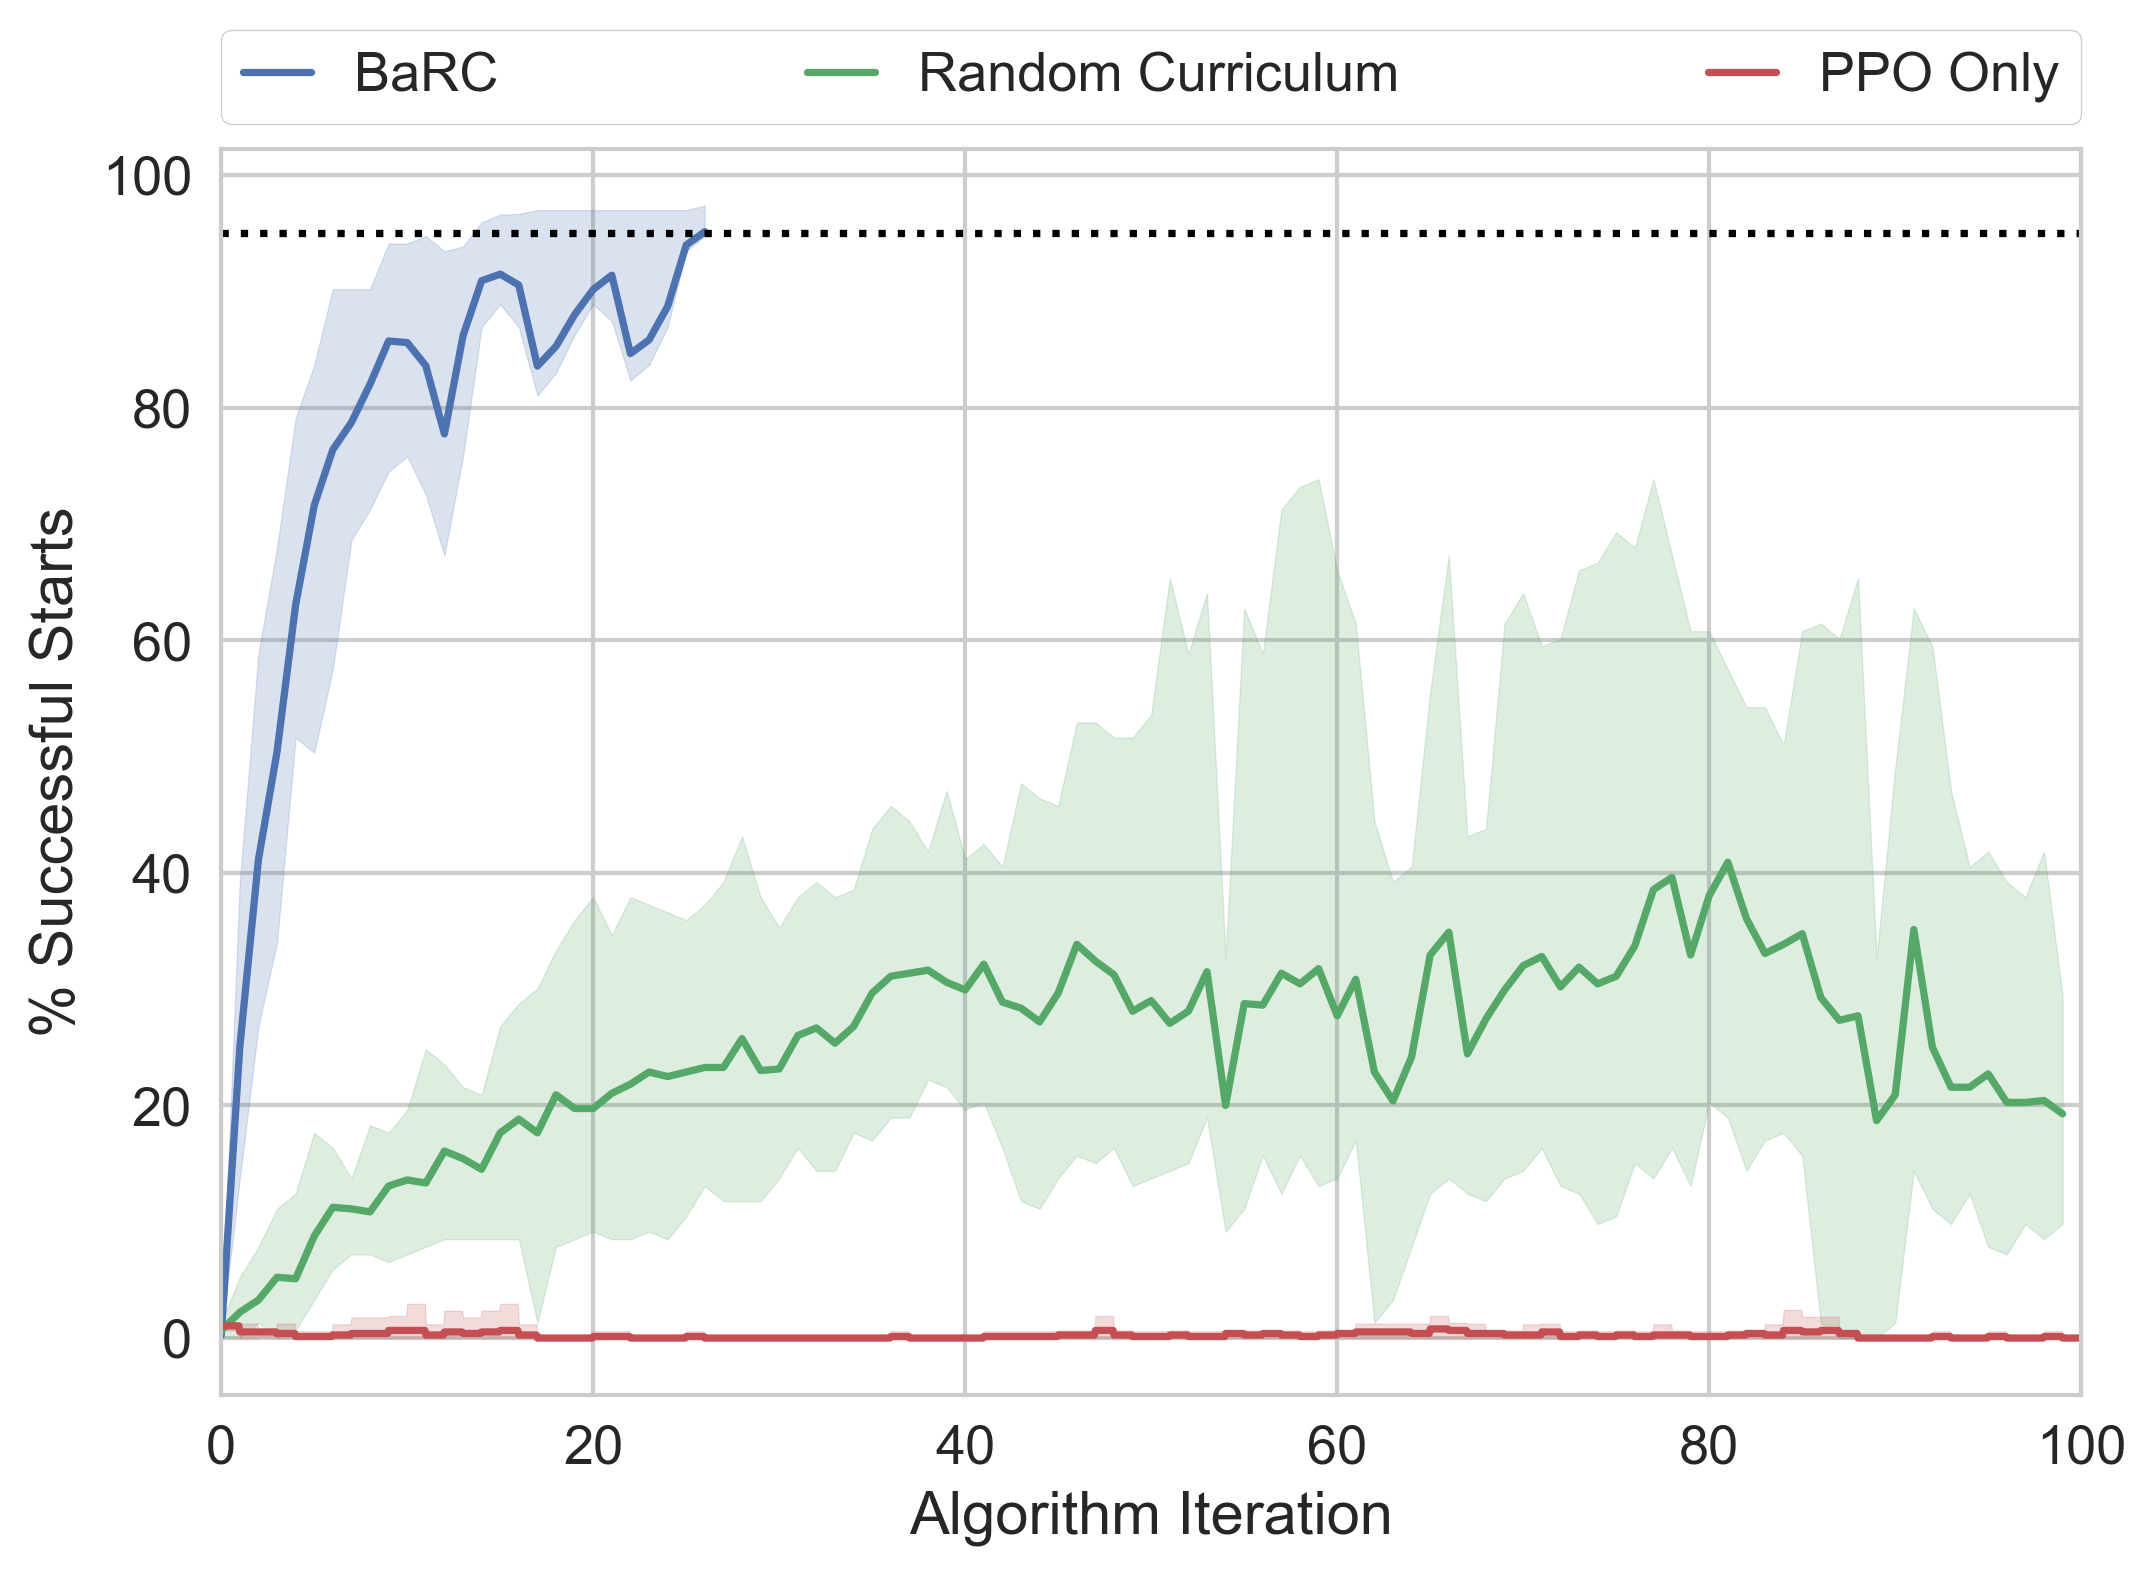

In [39]:
fig, ax = plt.subplots(dpi=300)
plot_ci_perf(ax=ax, df=our_overall_iter_df, x_col='overall_iter', y_col='overall_perf', label='BaRC');
plot_ci_perf(ax=ax, df=random_overall_iter_df, x_col='overall_iter', y_col='overall_perf', label='Random Curriculum');
plot_ci_perf(ax=ax, df=ppo_only_overall_iter_df, x_col='overall_iter', y_col='overall_perf', label='PPO Only');
ax.axhline(95, linestyle=':', color='k');
ax.set_ylabel(r'% Successful Starts');
ax.set_xlabel('Algorithm Iteration');
ax.set_xlim((0, 100));
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
          mode="expand", borderaxespad=0, ncol=3,
          frameon=True, framealpha=1.0, handlelength=1.25);
plt.savefig('figures/car_no_error_alg_iter.pdf', dpi=300);

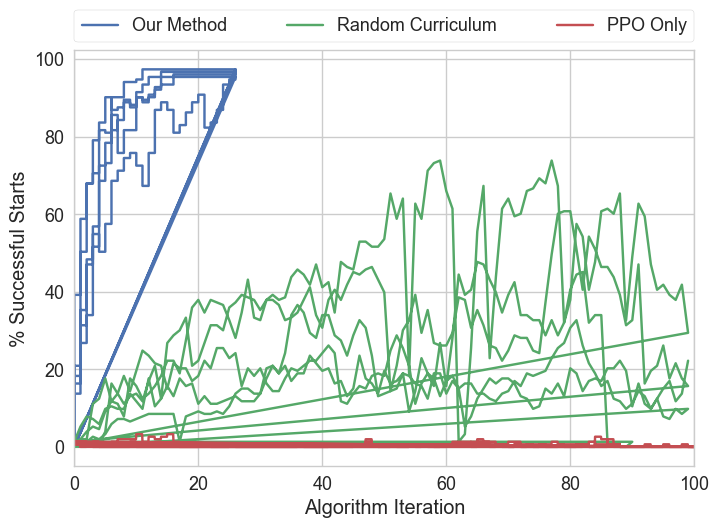

In [40]:
fig, ax = plt.subplots(dpi=100)
ax.plot(our_df['overall_iter'], our_df['overall_perf'], label='Our Method');
ax.plot(random_df['overall_iter'], random_df['overall_perf'], label='Random Curriculum');
ax.plot(ppo_only_df['overall_iter'], ppo_only_df['overall_perf'], label='PPO Only');
ax.set_ylabel(r'% Successful Starts')
ax.set_xlabel('Algorithm Iteration')
ax.set_xlim((0, 100))
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
          mode="expand", borderaxespad=0, ncol=3,
          frameon=True, framealpha=1.0);

In [41]:
concat_list = list()
max_iter = our_df['rel_time_bin'].max()
for run_seed in pd.unique(our_df['run_seed']):
#     print(run_seed)
    run_seed_df = our_df[our_df['run_seed'] == run_seed]
    curr_max_iter = run_seed_df['rel_time_bin'].max()
#     print(curr_max_iter)
    for i in np.arange(curr_max_iter, max_iter + 1, 5):
#         print("iter", i)
        new_data = pd.DataFrame(run_seed_df[-1:].values, columns=run_seed_df.columns)
        new_data['rel_time_bin'] = i
        run_seed_df = run_seed_df.append(new_data)
    concat_list.append(run_seed_df)

our_df = pd.concat(concat_list, ignore_index=True)
our_df = our_df.apply(pd.to_numeric, errors='ignore')

In [42]:
our_rel_time_df = our_df.groupby('rel_time_bin').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
random_rel_time_df = random_df.groupby('rel_time_bin').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
ppo_only_rel_time_df = ppo_only_df.groupby('rel_time_bin').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()

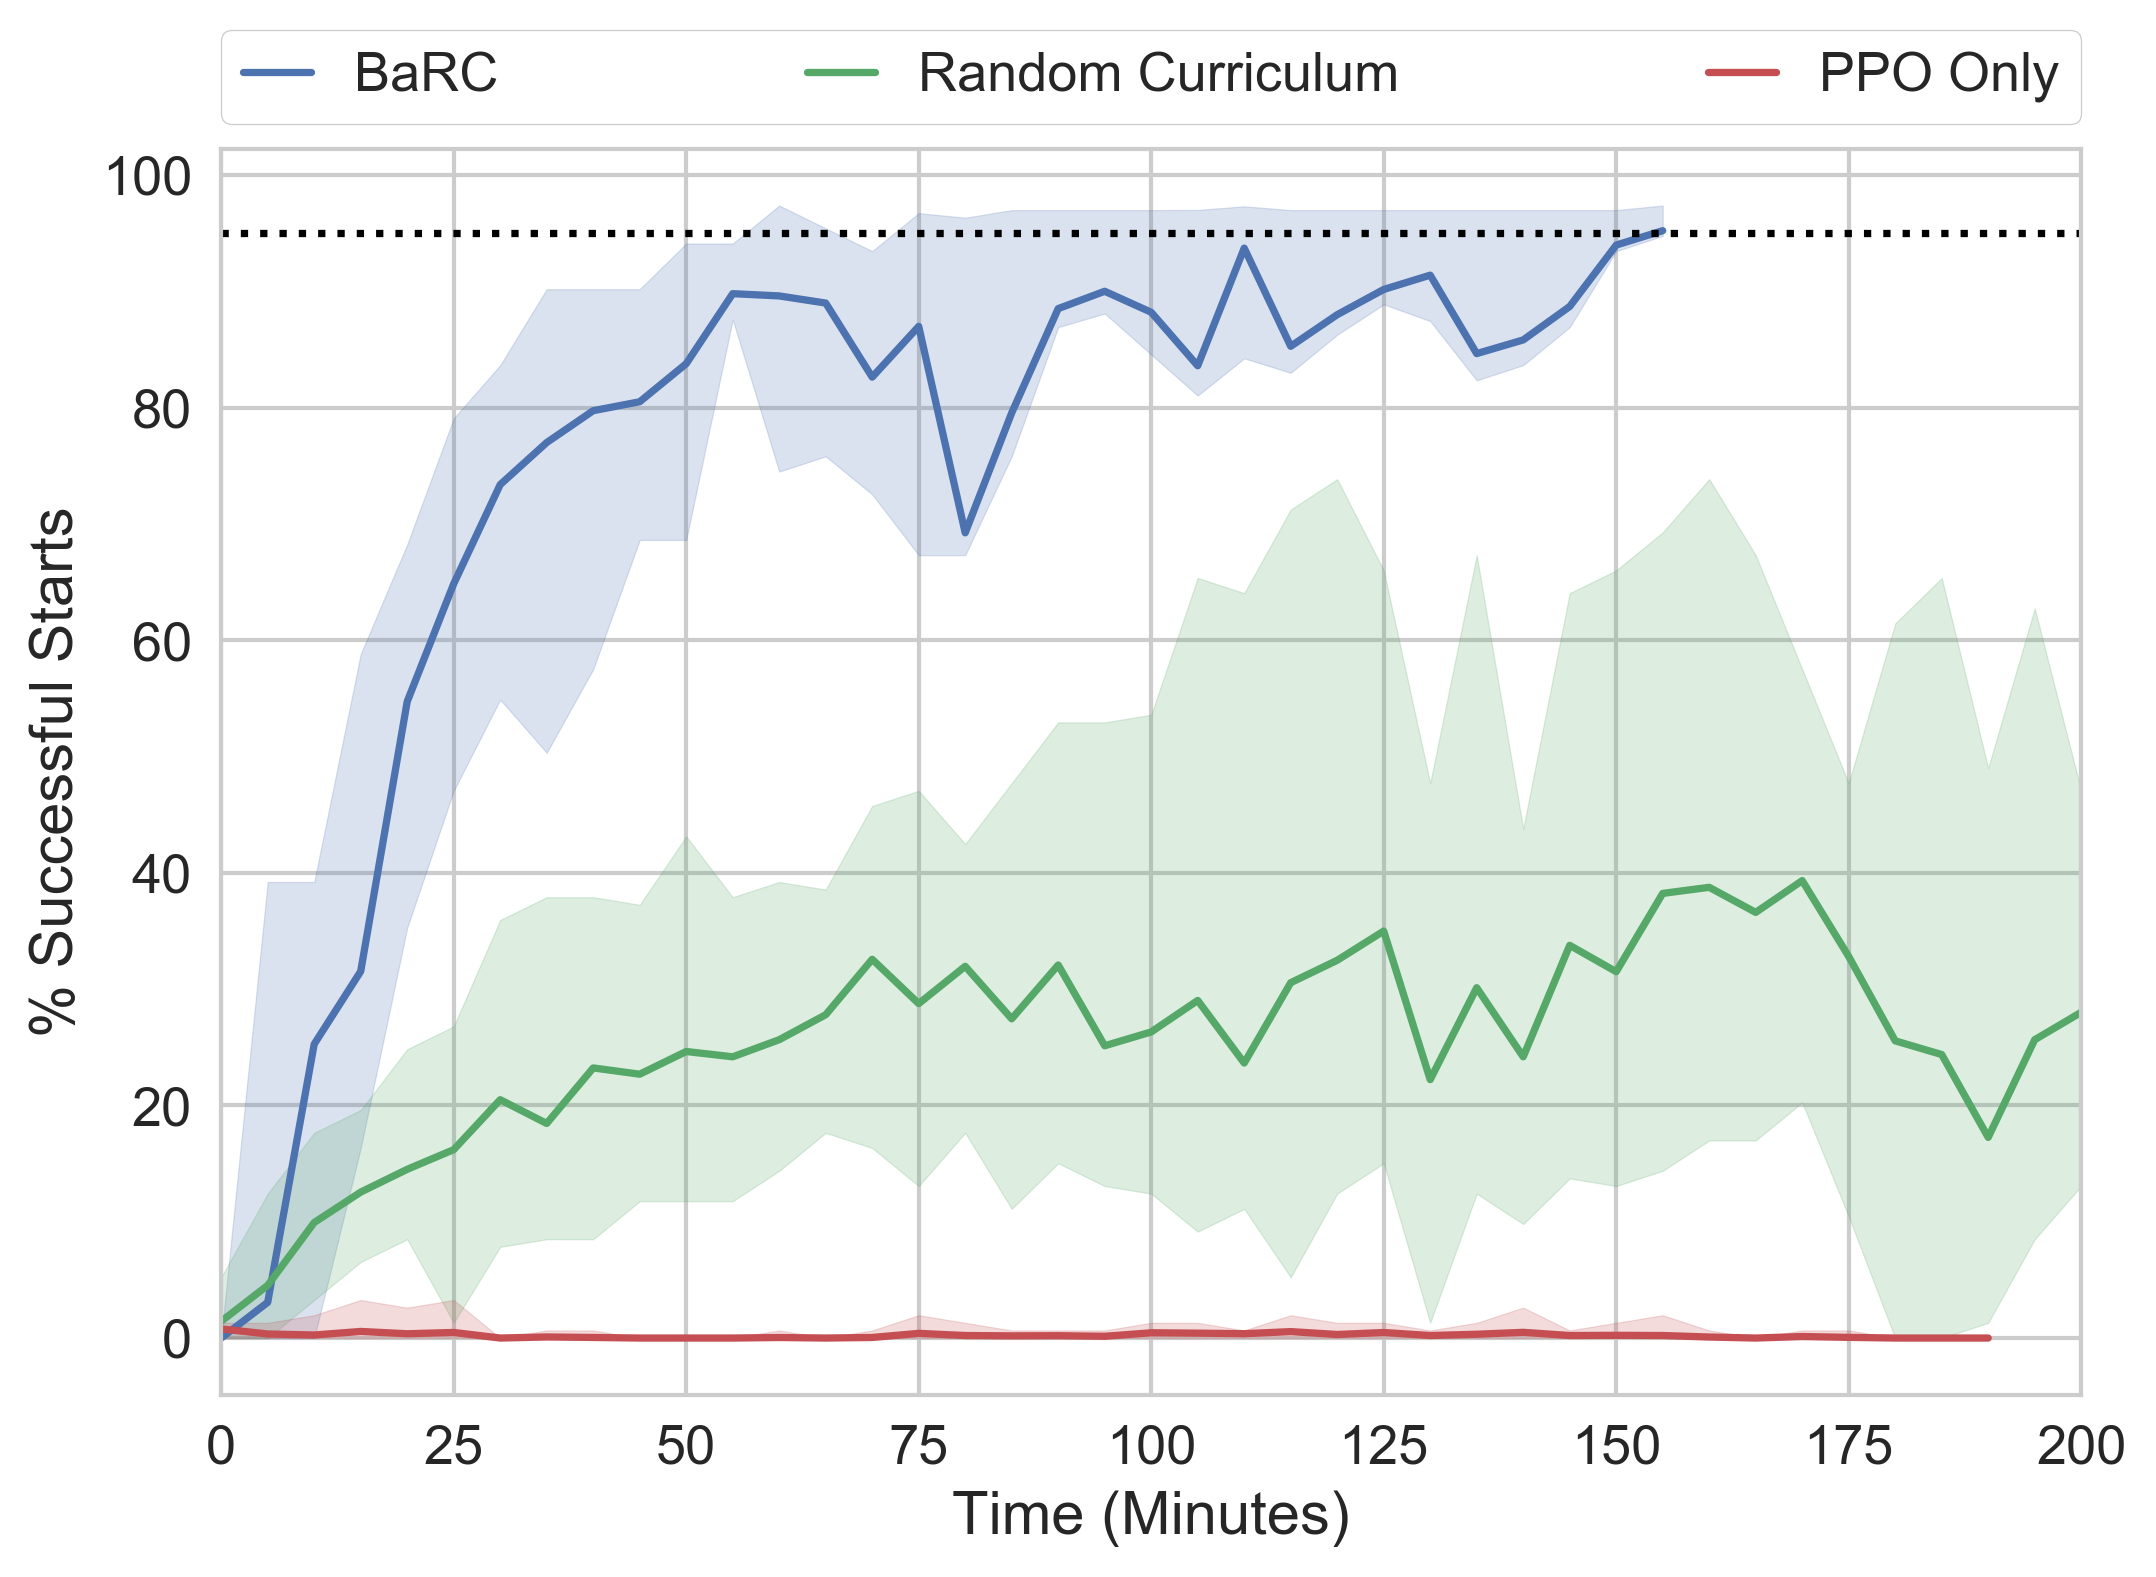

In [43]:
fig, ax = plt.subplots(dpi=300)
plot_ci_perf(ax=ax, df=our_rel_time_df, x_col='rel_time_bin', y_col='overall_perf', label='BaRC')
plot_ci_perf(ax=ax, df=random_rel_time_df, x_col='rel_time_bin', y_col='overall_perf', label='Random Curriculum')
plot_ci_perf(ax=ax, df=ppo_only_rel_time_df, x_col='rel_time_bin', y_col='overall_perf', label='PPO Only')
ax.axhline(95, linestyle=':', color='k');
ax.set_ylabel(r'% Successful Starts')
ax.set_xlabel('Time (Minutes)')
ax.set_xlim((0, 200))
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
          mode="expand", borderaxespad=0, ncol=3,
          frameon=True, framealpha=1.0, handlelength=1.25);
plt.savefig('figures/car_no_error_minutes.pdf', dpi=300);

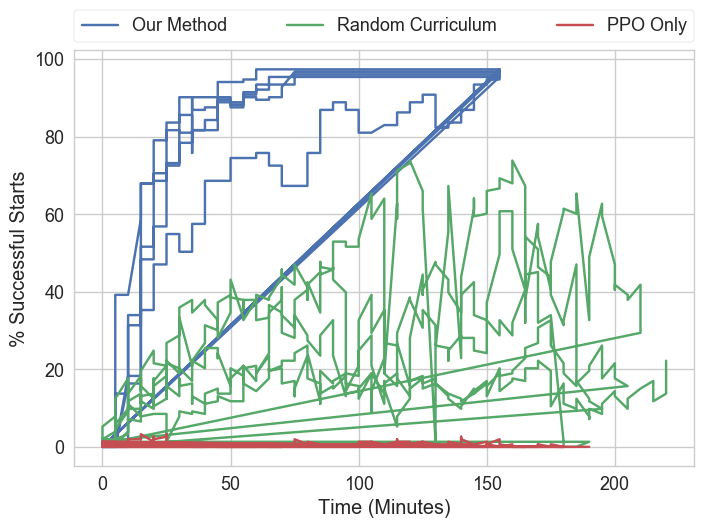

In [44]:
fig, ax = plt.subplots(dpi=100)
ax.plot(our_df['rel_time_bin'], our_df['overall_perf'], label='Our Method');
ax.plot(random_df['rel_time_bin'], random_df['overall_perf'], label='Random Curriculum');
ax.plot(ppo_only_df['rel_time_bin'], ppo_only_df['overall_perf'], label='PPO Only');
ax.set_ylabel(r'% Successful Starts')
ax.set_xlabel('Time (Minutes)')
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
          mode="expand", borderaxespad=0, ncol=3,
          frameon=True, framealpha=1.0);

In [45]:
our_df['ppo_iteration_correct'] = our_df.groupby('run_seed').cumcount()

In [46]:
our_ppo_iter_df = our_df.groupby('ppo_iteration_correct').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
random_ppo_iter_df = random_df.groupby('ppo_iter').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
ppo_only_ppo_iter_df = ppo_only_df.groupby('ppo_iter').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()

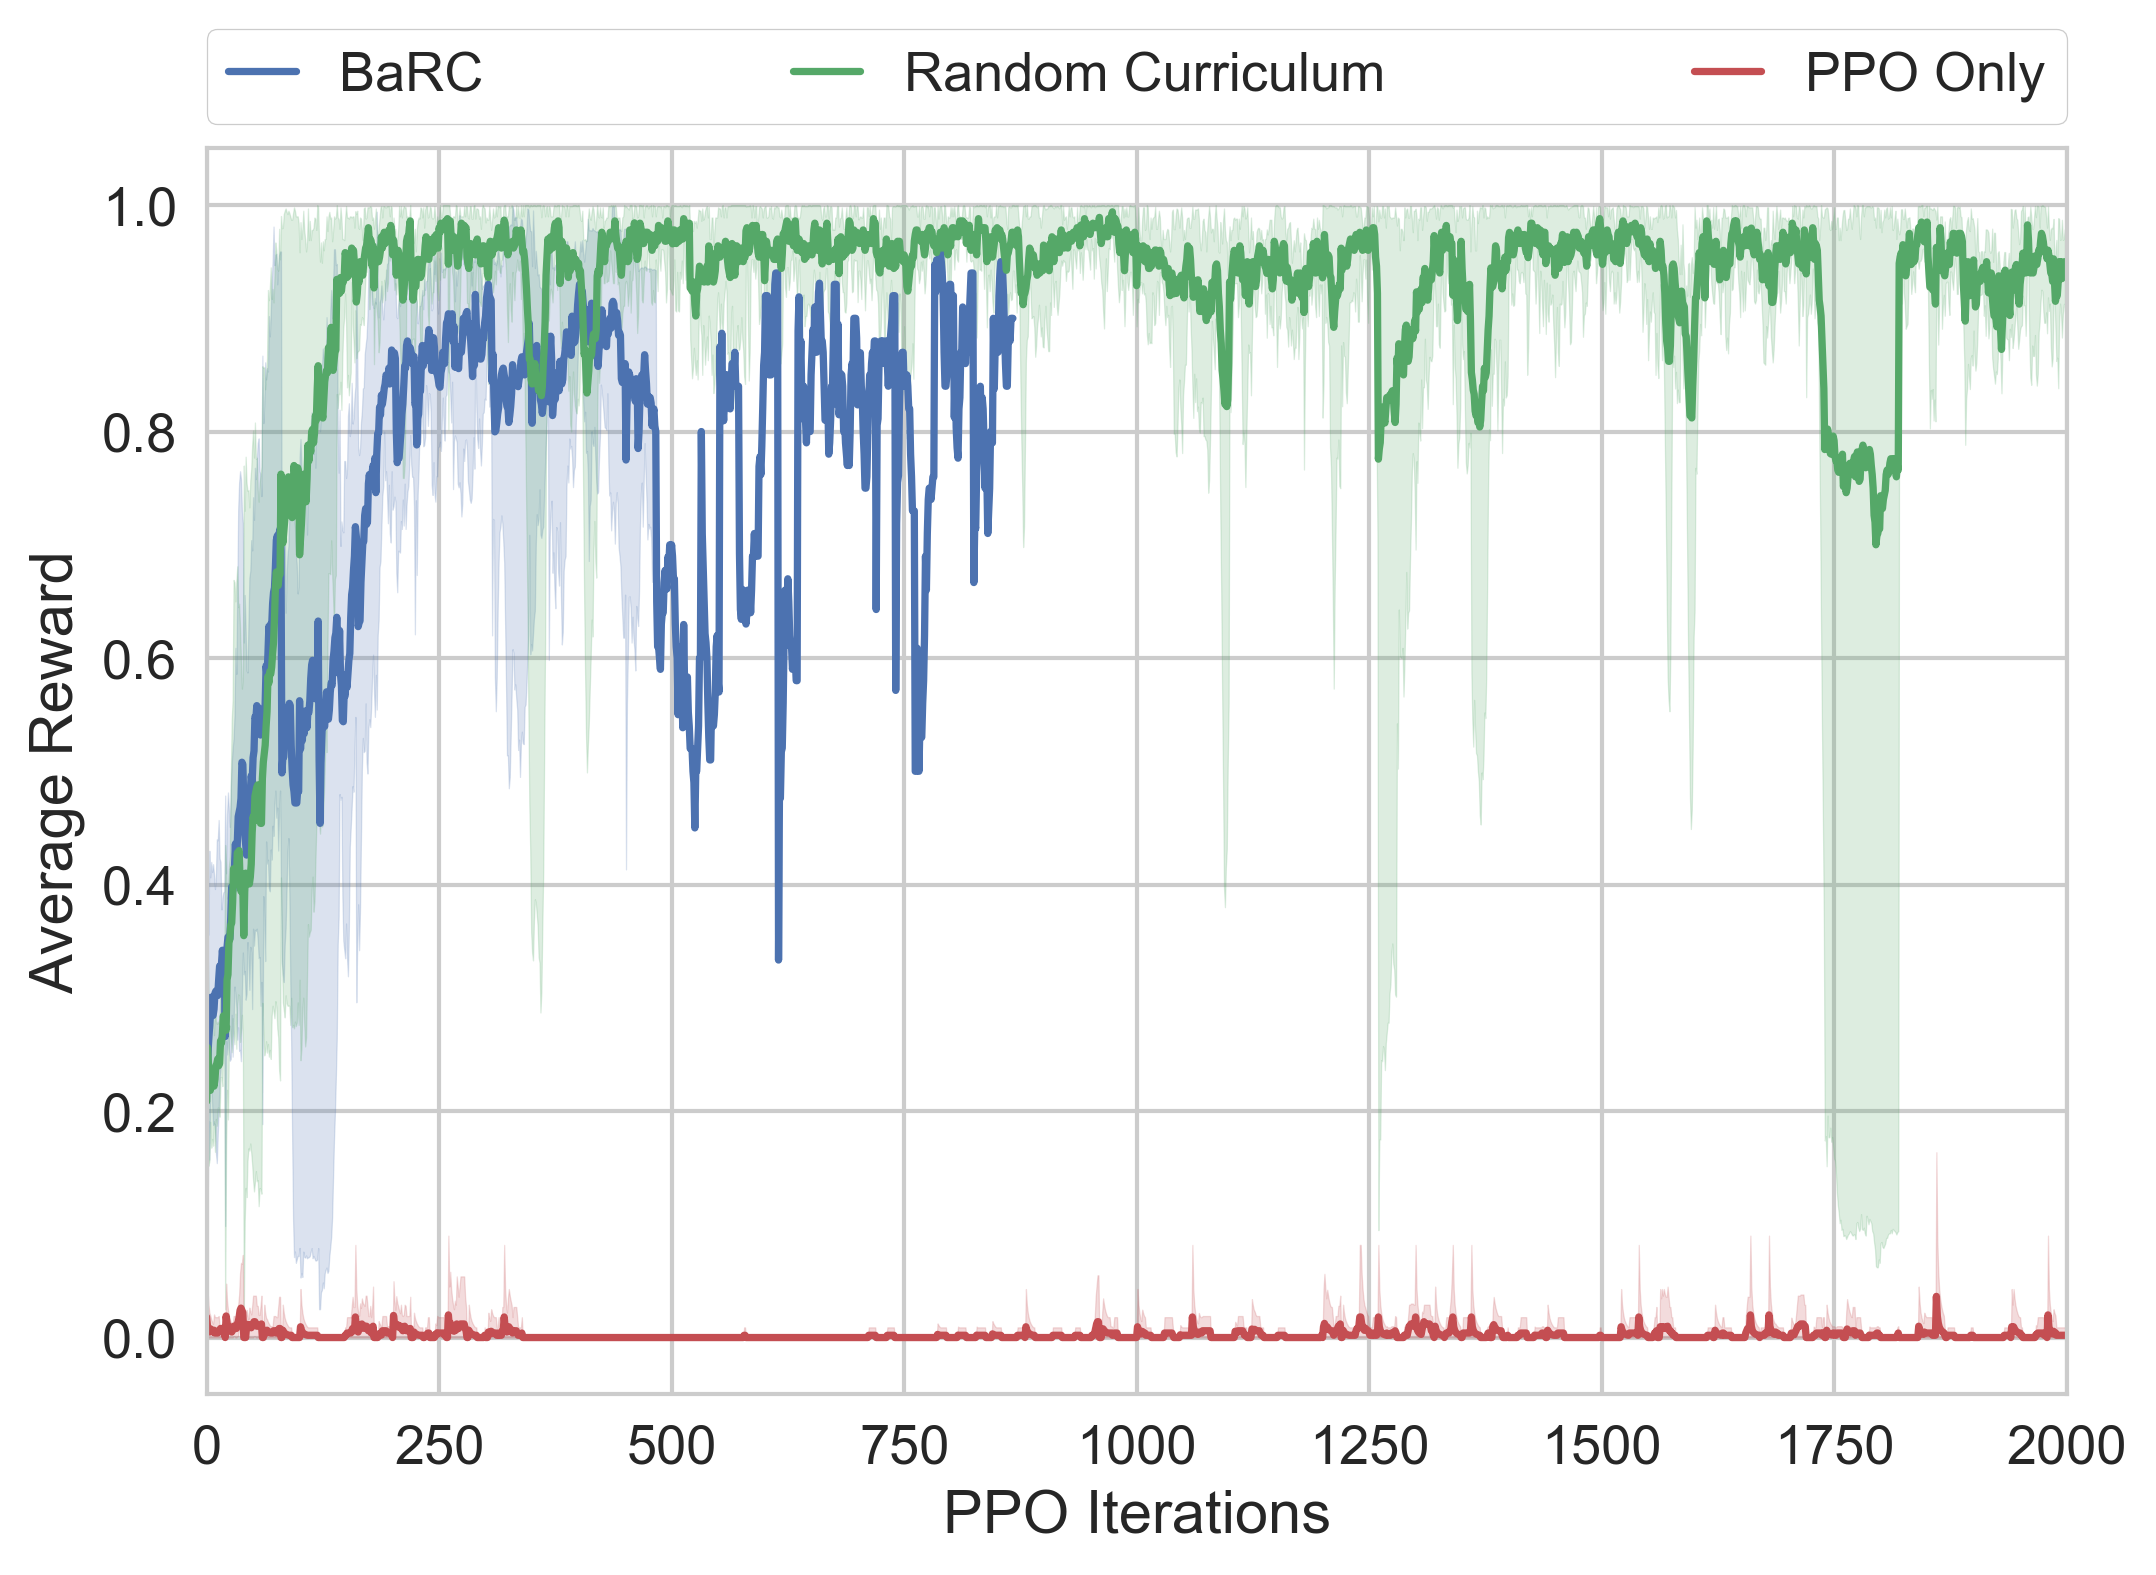

In [47]:
fig, ax = plt.subplots(dpi=300)
plot_ci_perf(ax=ax, df=our_ppo_iter_df, x_col='ppo_iteration_correct', y_col='ppo_rews', label='BaRC')
plot_ci_perf(ax=ax, df=random_ppo_iter_df, x_col='ppo_iter', y_col='ppo_rews', label='Random Curriculum')
plot_ci_perf(ax=ax, df=ppo_only_ppo_iter_df, x_col='ppo_iter', y_col='ppo_rews', label='PPO Only')
ax.set_ylabel(r'Average Reward')
ax.set_xlabel('PPO Iterations')
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
          mode="expand", borderaxespad=0, ncol=3,
          frameon=True, framealpha=1.0, handlelength=1.25);
plt.xlim((0, 2000))
plt.savefig('figures/car_no_error_ppo_iter.pdf', dpi=300)

# Error Models

In [48]:
path = 'good_error_runs'
all_files = glob.glob(os.path.join(path, "**/*.csv"), recursive=True)
df_from_each_file = (load_data(f, many_names=True) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)
# doesn't create a list, nor does it append to one

ValueError: No objects to concatenate

In [49]:
pd.unique(concatenated_df['run_name'])

array(['backreach', 'ppo', 'random'], dtype=object)

In [37]:
our_df = concatenated_df[concatenated_df['run_name'] == 'backreach_velocity_noise']
ppo_only_df = concatenated_df[concatenated_df['run_name'] == 'ppo_only_velocity_noise']
random_df = concatenated_df[concatenated_df['run_name'] == 'random_velocity_noise']

In [38]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [39]:
def plot_ci_perf(ax, df, x_col, y_col, label=None):
    p = ax.plot(df[x_col], df[y_col], label=label);

In [40]:
our_overall_iter_df = our_df.groupby('overall_iter').mean().reset_index()
random_overall_iter_df = random_df.groupby('overall_iter').mean().reset_index()
ppo_only_overall_iter_df = ppo_only_df.groupby('overall_iter').mean().reset_index()

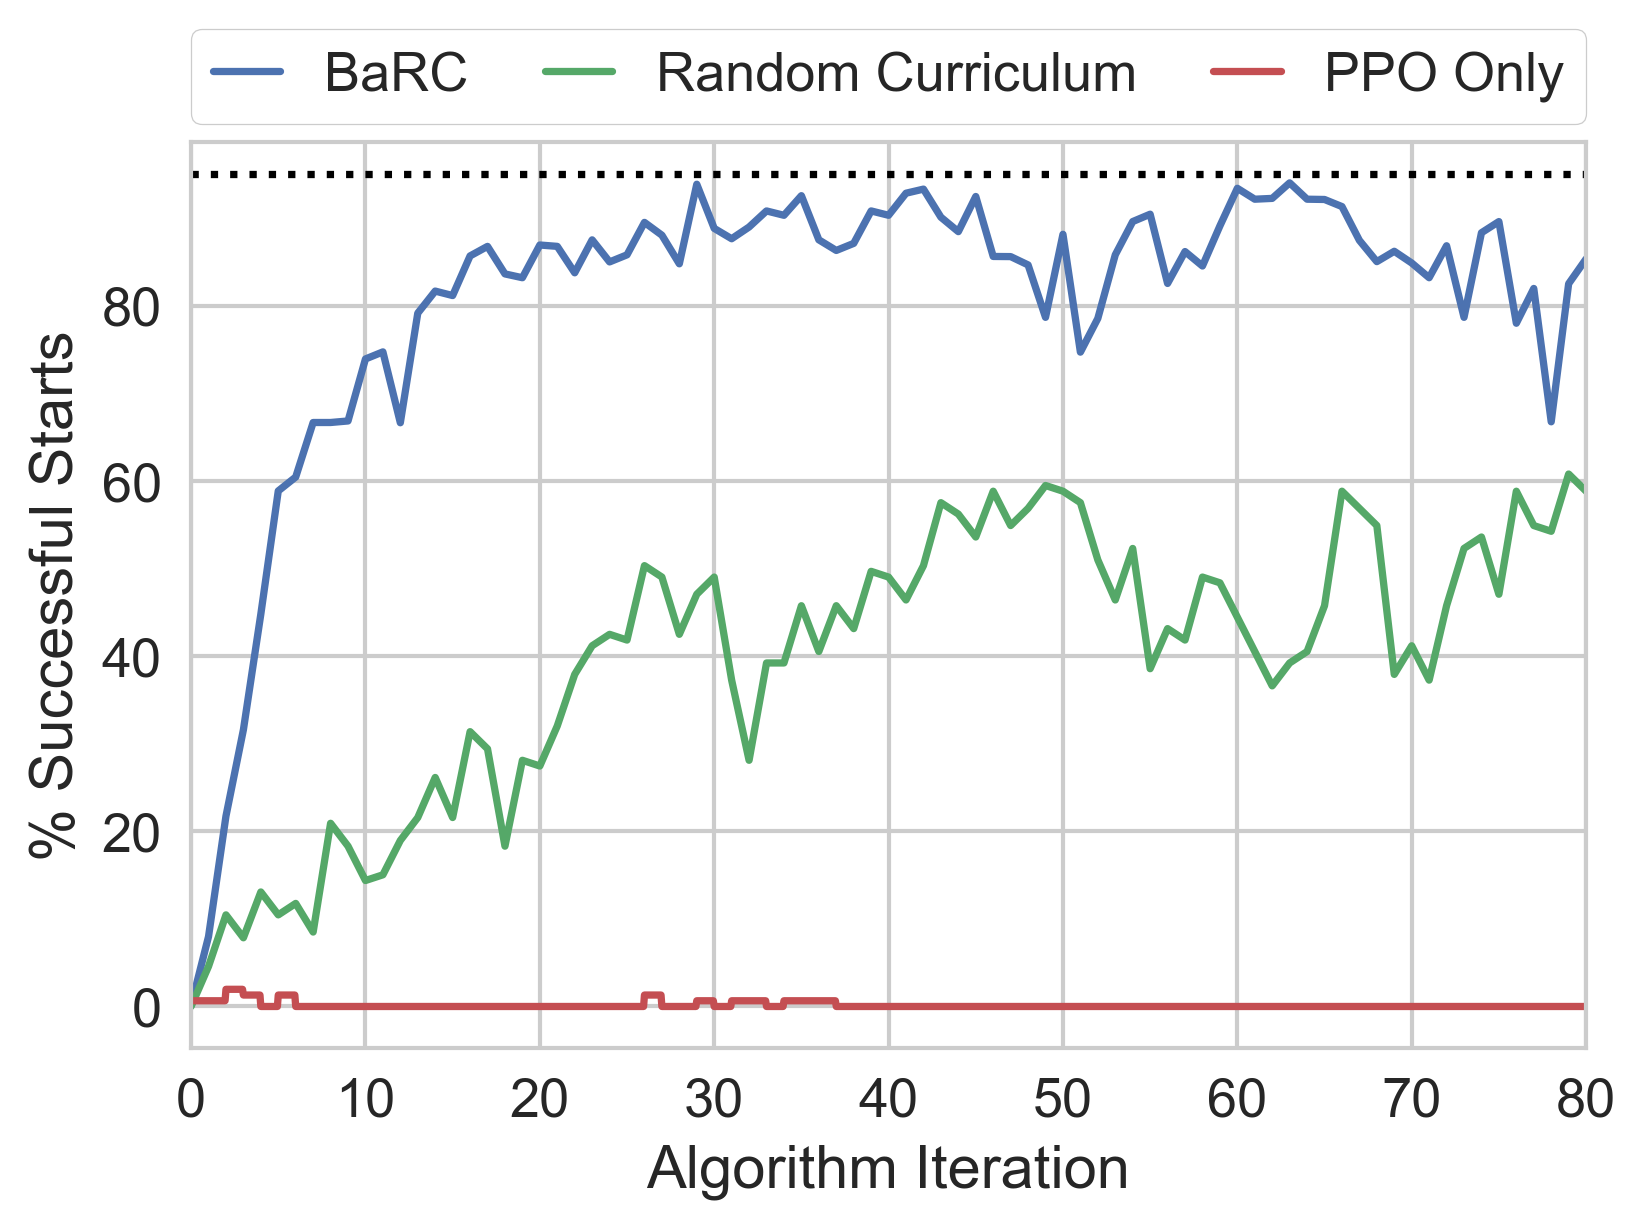

In [43]:
fig, ax = plt.subplots(dpi=300)
plot_ci_perf(ax=ax, df=our_overall_iter_df, x_col='overall_iter', y_col='overall_perf', label='BaRC');
plot_ci_perf(ax=ax, df=random_overall_iter_df, x_col='overall_iter', y_col='overall_perf', label='Random Curriculum');
plot_ci_perf(ax=ax, df=ppo_only_overall_iter_df, x_col='overall_iter', y_col='overall_perf', label='PPO Only');
ax.axhline(95, linestyle=':', color='k');
ax.set_ylabel(r'% Successful Starts');
ax.set_xlabel('Algorithm Iteration');
ax.set_xlim((0, 80));
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
          mode="expand", borderaxespad=0, ncol=3,
          frameon=True, framealpha=1.0, handlelength=1.25);
plt.savefig('figures/car_error_velocity_noise.pdf', dpi=300)

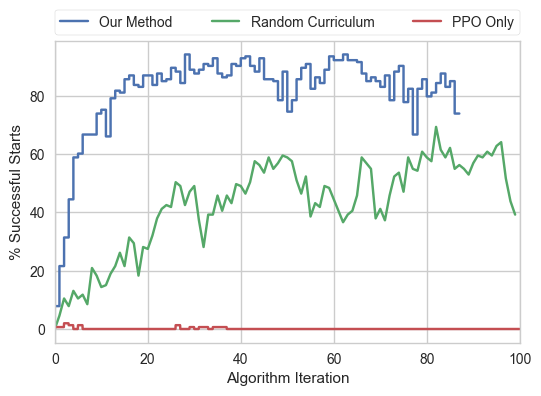

In [40]:
fig, ax = plt.subplots(dpi=100)
ax.plot(our_df['overall_iter'], our_df['overall_perf'], label='Our Method');
ax.plot(random_df['overall_iter'], random_df['overall_perf'], label='Random Curriculum');
ax.plot(ppo_only_df['overall_iter'], ppo_only_df['overall_perf'], label='PPO Only');
ax.set_ylabel(r'% Successful Starts')
ax.set_xlabel('Algorithm Iteration')
ax.set_xlim((0, 100))
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
          mode="expand", borderaxespad=0, ncol=3,
          frameon=True, framealpha=1.0);

In [42]:
our_rel_time_df = our_df.groupby('rel_time_bin').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
random_rel_time_df = random_df.groupby('rel_time_bin').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
ppo_only_rel_time_df = ppo_only_df.groupby('rel_time_bin').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()

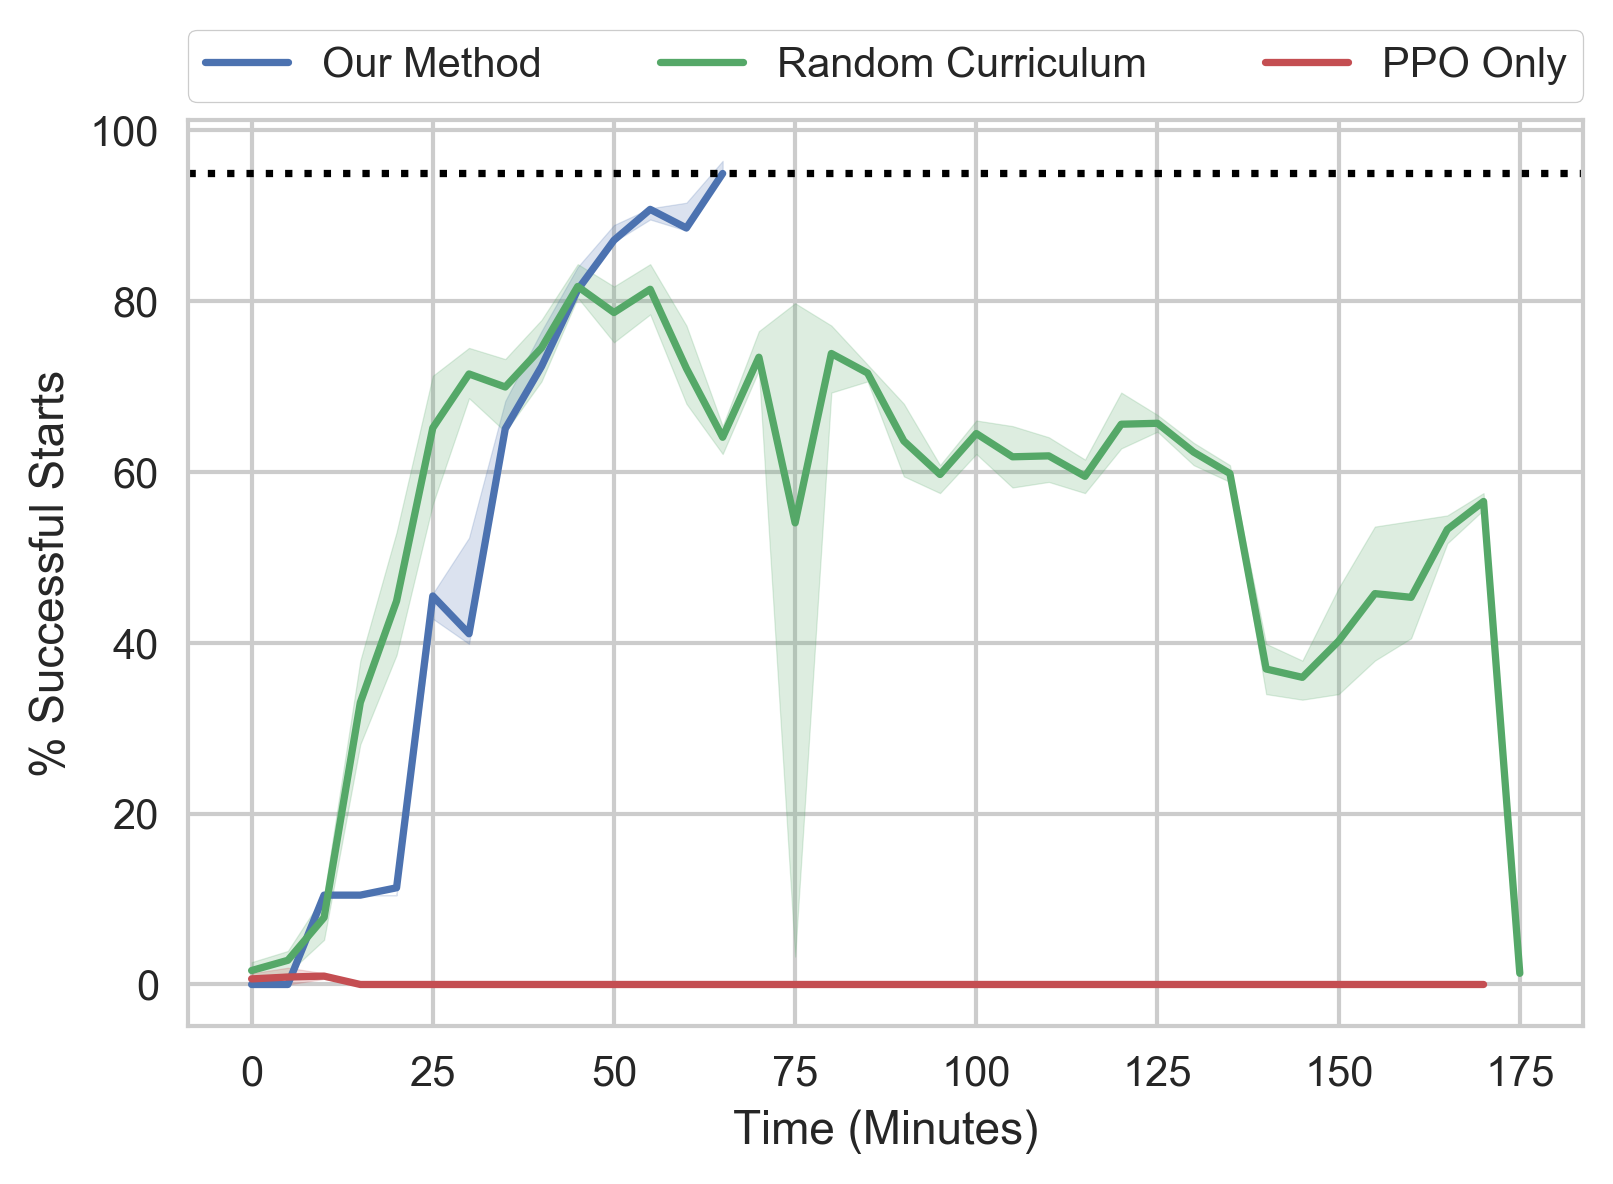

In [13]:
fig, ax = plt.subplots(dpi=300)
plot_ci_perf(ax=ax, df=our_rel_time_df, x_col='rel_time_bin', y_col='overall_perf', label='Our Method')
plot_ci_perf(ax=ax, df=random_rel_time_df, x_col='rel_time_bin', y_col='overall_perf', label='Random Curriculum')
plot_ci_perf(ax=ax, df=ppo_only_rel_time_df, x_col='rel_time_bin', y_col='overall_perf', label='PPO Only')
ax.axhline(95, linestyle=':', color='k');
ax.set_ylabel(r'% Successful Starts')
ax.set_xlabel('Time (Minutes)')
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
          mode="expand", borderaxespad=0, ncol=3,
          frameon=True, framealpha=1.0);

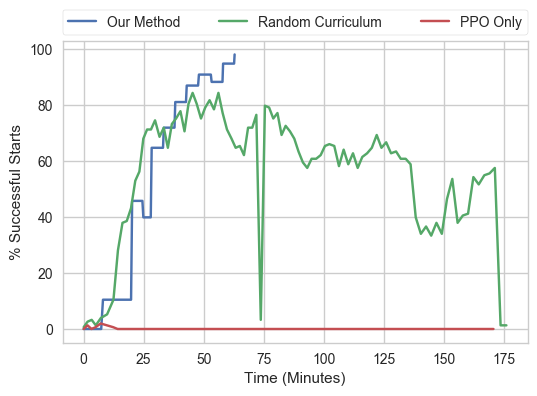

In [14]:
fig, ax = plt.subplots(dpi=100)
ax.plot(our_df['rel_time'], our_df['overall_perf'], label='Our Method');
ax.plot(random_df['rel_time'], random_df['overall_perf'], label='Random Curriculum');
ax.plot(ppo_only_df['rel_time'], ppo_only_df['overall_perf'], label='PPO Only');
ax.set_ylabel(r'% Successful Starts')
ax.set_xlabel('Time (Minutes)')
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
          mode="expand", borderaxespad=0, ncol=3,
          frameon=True, framealpha=1.0);

In [15]:
our_df['ppo_iteration_correct'] = our_df.groupby('run_seed').cumcount()

/Users/borisi/anaconda2/envs/backreach/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
our_ppo_iter_df = our_df.groupby('ppo_iteration_correct').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
random_ppo_iter_df = random_df.groupby('ppo_iter').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
ppo_only_ppo_iter_df = ppo_only_df.groupby('ppo_iter').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()

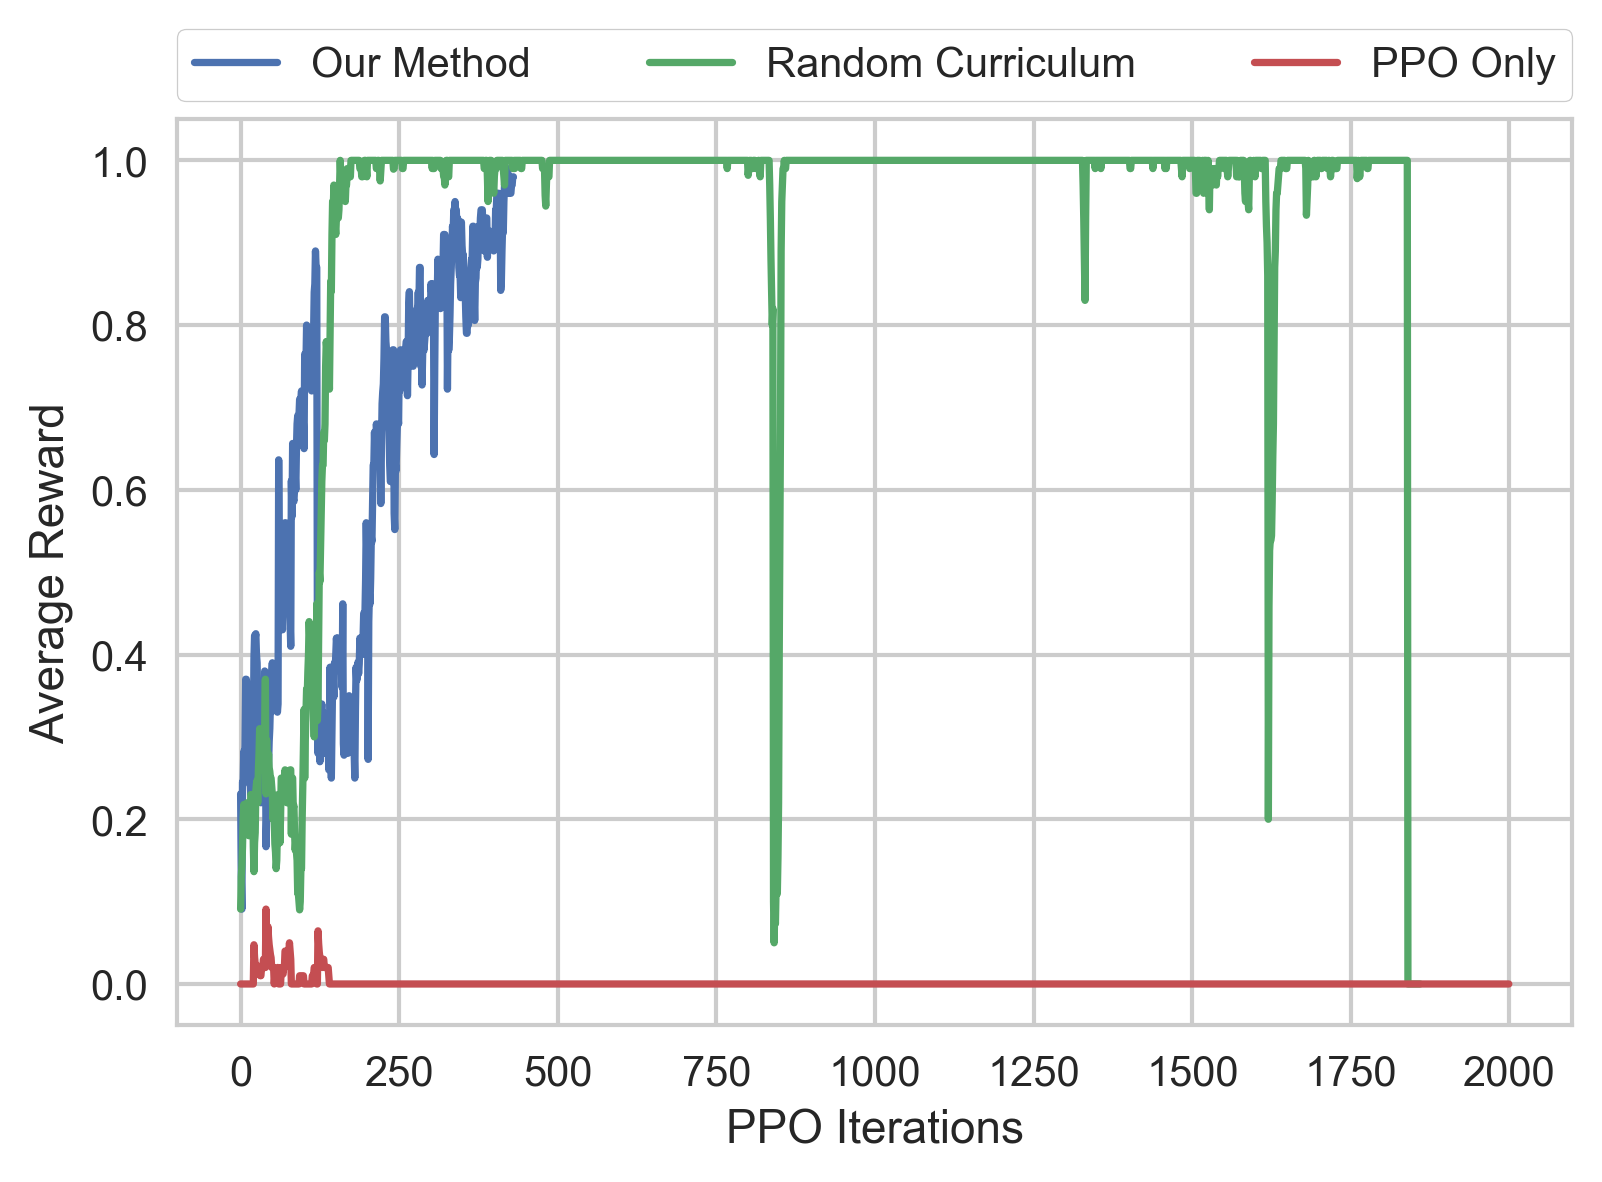

In [17]:
fig, ax = plt.subplots(dpi=300)
plot_ci_perf(ax=ax, df=our_ppo_iter_df, x_col='ppo_iteration_correct', y_col='ppo_rews', label='Our Method')
plot_ci_perf(ax=ax, df=random_ppo_iter_df, x_col='ppo_iter', y_col='ppo_rews', label='Random Curriculum')
plot_ci_perf(ax=ax, df=ppo_only_ppo_iter_df, x_col='ppo_iter', y_col='ppo_rews', label='PPO Only')
ax.set_ylabel(r'Average Reward')
ax.set_xlabel('PPO Iterations')
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
          mode="expand", borderaxespad=0, ncol=3,
          frameon=True, framealpha=1.0);

# Zero Goal Velocity Experiments

In [9]:
our_zgv_df = load_data('backreach_tgv_10-Jun-2018_02-04-44/data/data_backreach.csv')
random_zgv_df = load_data('random_tgv_10-Jun-2018_02-04-44/data/data_random.csv')
ppo_zgv_df = load_data('ppo_only_tgv_10-Jun-2018_02-04-44/data/data_ppo_only.csv')

In [10]:
our_zgv_df['source'] = 'ours'
random_zgv_df['source'] = 'rand'
ppo_zgv_df['source'] = 'ppo'

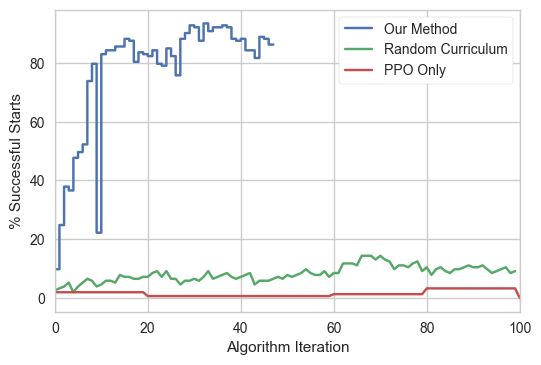

In [11]:
fig, ax = plt.subplots(dpi=100)
ax.plot(our_zgv_df['overall_iter'], our_zgv_df['overall_perf'], label='Our Method');
ax.plot(random_zgv_df['overall_iter'], random_zgv_df['overall_perf'], label='Random Curriculum');
ax.plot(ppo_zgv_df['overall_iter'], ppo_zgv_df['overall_perf'], label='PPO Only');
ax.set_ylabel(r'% Successful Starts')
ax.set_xlabel('Algorithm Iteration')
ax.set_xlim((0, 100))
ax.legend(loc='best', frameon=True, framealpha=1.0);

# Quad Experiments

In [4]:
path = 'runs'
all_files = [x for x in glob.glob(os.path.join(path, "**/*.csv"), recursive=True)]
df_from_each_file = (load_data(f, many_names=True) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)
# doesn't create a list, nor does it append to one

In [5]:
pd.unique(concatenated_df['run_name'])

array(['PlanarQuad-v0_backreach_var1', 'PlanarQuad-v0_backreach_var2',
       'PlanarQuad-v0_ppo_only_var1',
       'PlanarQuad-v0_ppo_only_var1_seed_2018',
       'PlanarQuad-v0_ppo_only_var1_seed_2020',
       'PlanarQuad-v0_ppo_only_var1_seed_2021',
       'PlanarQuad-v0_ppo_only_var1_seed_2022',
       'PlanarQuad-v0_ppo_only_var1_seed_2024',
       'PlanarQuad-v0_ppo_only_var1_seed_2028',
       'PlanarQuad-v0_ppo_only_var1_seed_2030',
       'PlanarQuad-v0_ppo_only_var1_seed_2031',
       'PlanarQuad-v0_ppo_only_var1_seed_2032',
       'PlanarQuad-v0_ppo_only_var1_seed_2034',
       'PlanarQuad-v0_ppo_only_var2', 'PlanarQuad-v0_random_var1',
       'PlanarQuad-v0_random_var2'], dtype=object)

In [6]:
# Not hovering at the goal
our_df = concatenated_df[concatenated_df['run_name'] == 'PlanarQuad-v0_backreach_var2']
ppo_only_df = concatenated_df[concatenated_df['run_name'] == 'PlanarQuad-v0_ppo_only_var2']
ppo_only_quad_rew_df = concatenated_df[concatenated_df['run_name'].str.contains('PlanarQuad-v0_ppo_only_var1')]
random_df = concatenated_df[concatenated_df['run_name'] == 'PlanarQuad-v0_random_var2']

In [7]:
# # Hovering at the goal
# our_df = concatenated_df[concatenated_df['run_name'] == 'PlanarQuad-v0_backreach_hover_at_end']
# ppo_only_df = concatenated_df[concatenated_df['run_name'] == 'PlanarQuad-v0_ppo_only_hover_at_end']
# random_df = concatenated_df[concatenated_df['run_name'] == 'PlanarQuad-v0_random_hover_at_end']

In [8]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [9]:
def plot_ci_perf(ax, df, x_col, y_col, label=None, color=None):
    if color is None:
        p = ax.plot(df[x_col], df[y_col, 'mean'], label=label);
    else:
        p = ax.plot(df[x_col], df[y_col, 'mean'], label=label, color=color);
    color = p[0].get_color();
    ax.fill_between(df[x_col], df[y_col, 'percentile_2.5'], df[y_col, 'percentile_97.5'], color=color, alpha=0.2);

In [10]:
# concat_list = list()
# max_iter = our_df['overall_iter'].max()
# for run_seed in pd.unique(our_df['run_seed']):
# #     print(run_seed)
#     run_seed_df = our_df[our_df['run_seed'] == run_seed]
#     curr_max_iter = run_seed_df['overall_iter'].max()
# #     print(curr_max_iter)
#     for i in np.arange(curr_max_iter + 1, max_iter + 1):
# #         print("iter", i)
#         new_data = pd.DataFrame(run_seed_df[-1:].values, columns=run_seed_df.columns)
#         new_data['overall_iter'] = i
#         run_seed_df = run_seed_df.append(new_data)
#     concat_list.append(run_seed_df)

# our_df = pd.concat(concat_list, ignore_index=True)
# our_df = our_df.apply(pd.to_numeric, errors='ignore')

In [11]:
our_df = our_df[our_df['rel_time'] < 120]

In [12]:
our_overall_iter_df = our_df.groupby('overall_iter').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
random_overall_iter_df = random_df.groupby('overall_iter').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
ppo_only_overall_iter_df = ppo_only_df.groupby('overall_iter').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
ppo_only_qr_overall_iter_df = ppo_only_quad_rew_df.groupby('overall_iter').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()

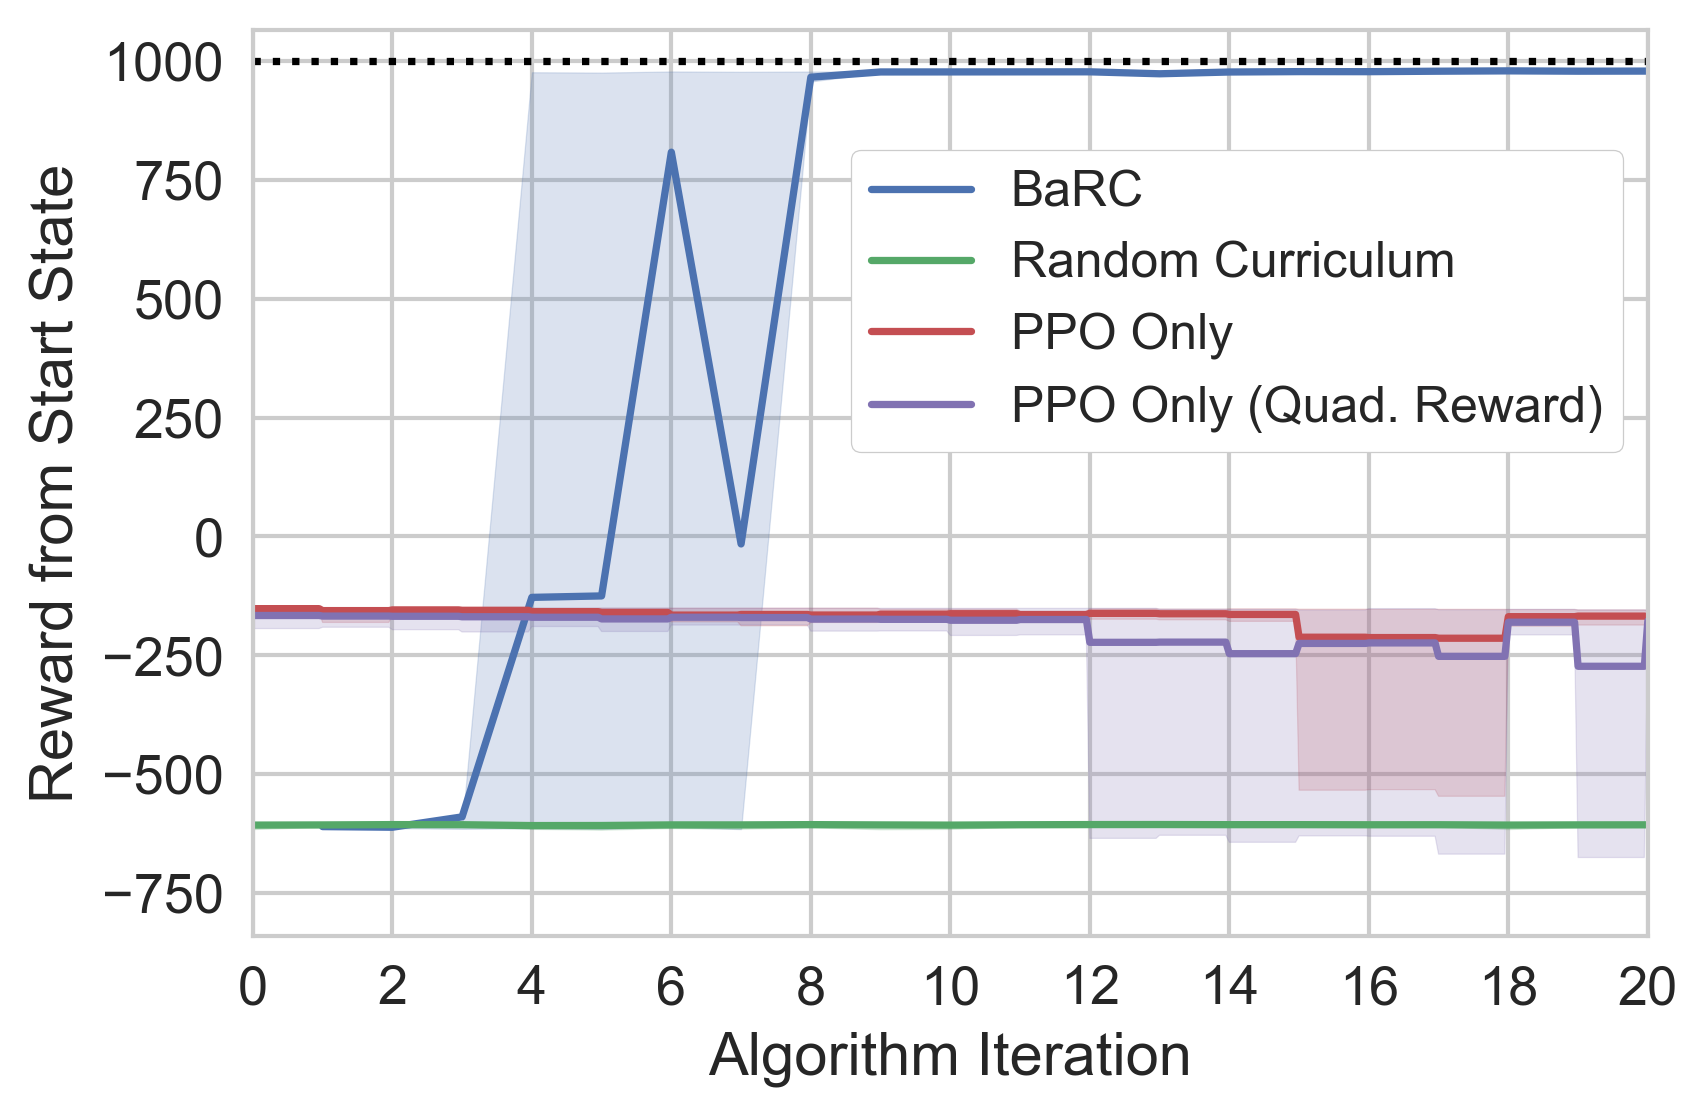

In [13]:
fig, ax = plt.subplots(dpi=300)
plot_ci_perf(ax=ax, df=our_overall_iter_df[1:], x_col='overall_iter', y_col='overall_perf', label='BaRC');
plot_ci_perf(ax=ax, df=random_overall_iter_df, x_col='overall_iter', y_col='overall_perf', label='Random Curriculum');
plot_ci_perf(ax=ax, df=ppo_only_overall_iter_df, x_col='overall_iter', y_col='overall_perf', label='PPO Only');
plot_ci_perf(ax=ax, df=ppo_only_qr_overall_iter_df, x_col='overall_iter', y_col='overall_perf', label='PPO Only (Quad. Reward)');
ax.axhline(1000, linestyle=':', color='k');
ax.set_ylabel(r'Reward from Start State');
ax.set_xlabel('Algorithm Iteration');
ax.set_xlim((0, 20));

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="center right", bbox_to_anchor=(1.0,0.7), ncol=1,
          frameon=True, framealpha=1.0, prop={'size': 12});

ax.set_xticks(range(0, 21, 2));
plt.savefig('figures/quad_rew_from_ss_all.pdf', dpi=300)

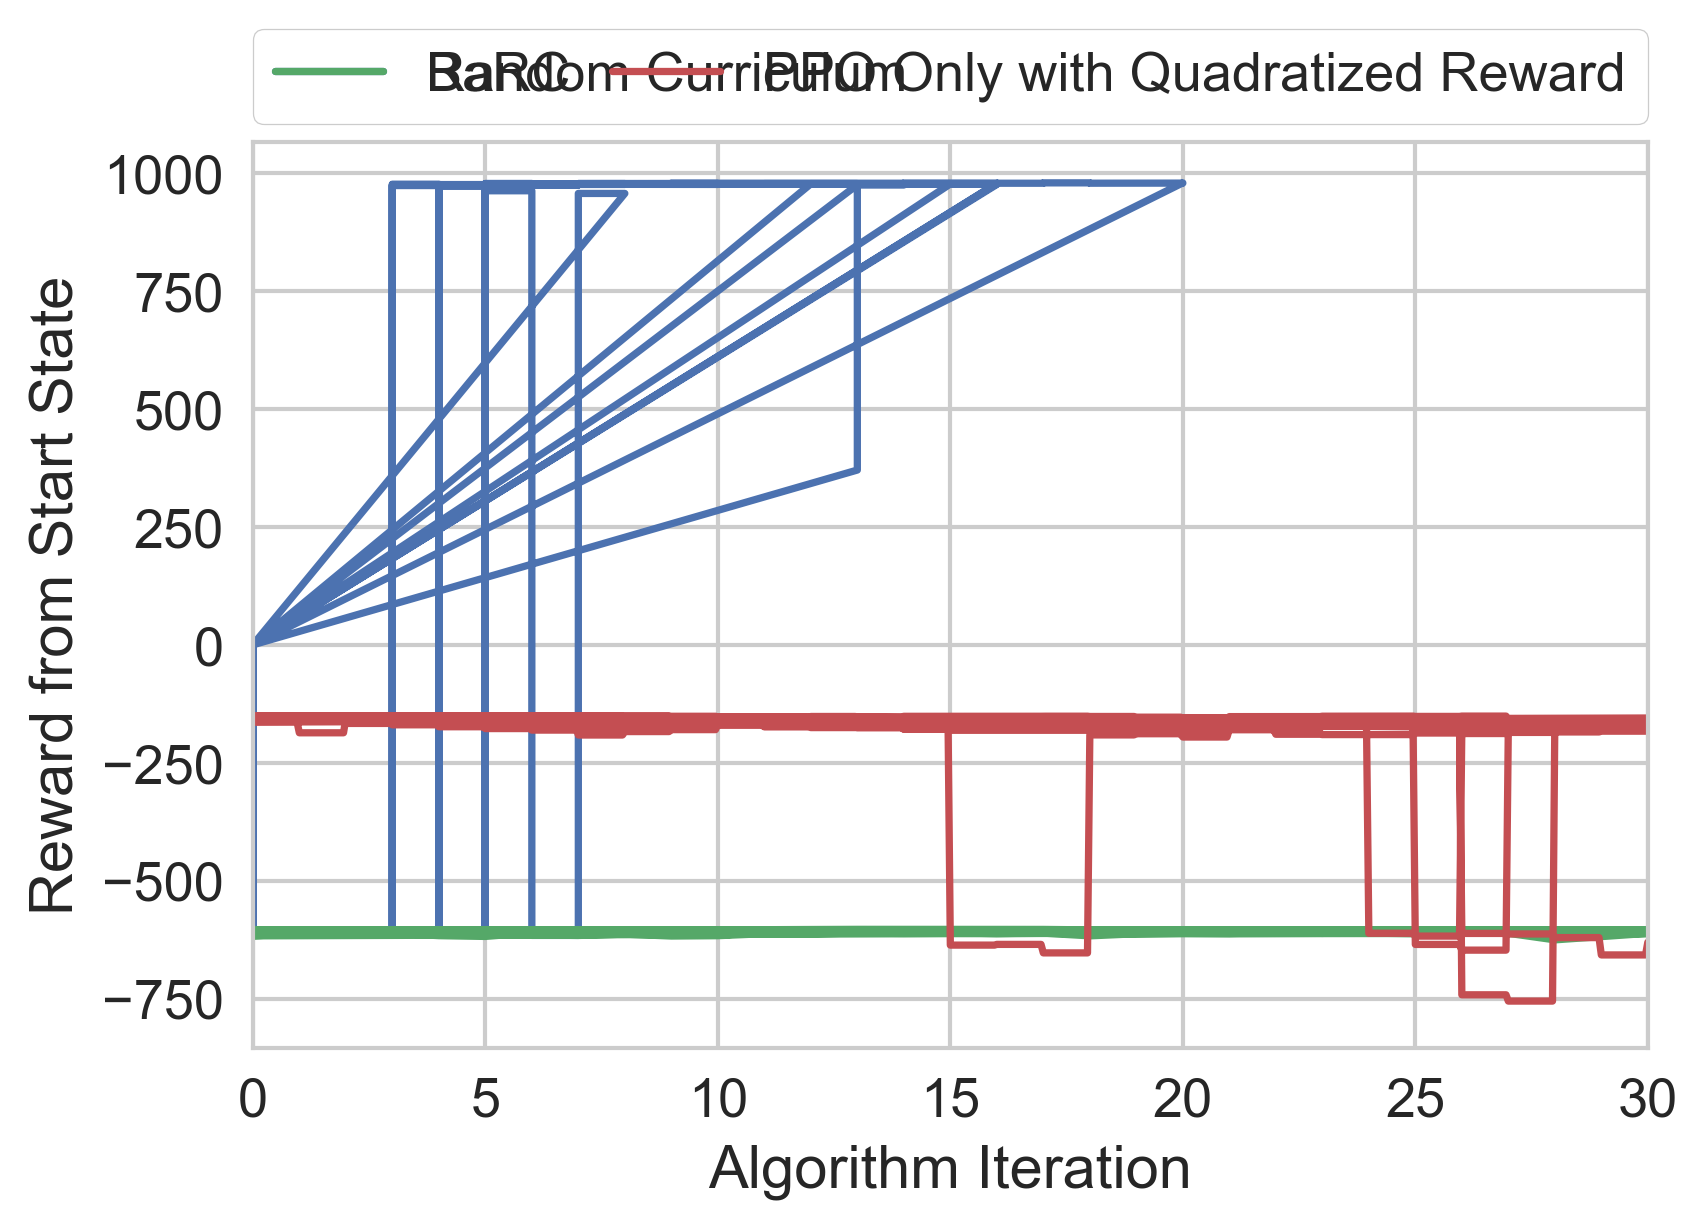

In [14]:
fig, ax = plt.subplots(dpi=300)
ax.plot(our_df['overall_iter'], our_df['overall_perf'], label='BaRC');
ax.plot(random_df['overall_iter'], random_df['overall_perf'], label='Random Curriculum');
ax.plot(ppo_only_df['overall_iter'], ppo_only_df['overall_perf'], label='PPO Only with Quadratized Reward', color=sns.color_palette()[2]);
ax.set_ylabel(r'Reward from Start State')
ax.set_xlabel('Algorithm Iteration')
ax.set_xlim((0, 30))
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
          mode="expand", borderaxespad=0, ncol=3,
          frameon=True, framealpha=1.0);

In [15]:
our_rel_time_df = our_df.groupby('rel_time_bin').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
random_rel_time_df = random_df.groupby('rel_time_bin').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
ppo_only_rel_time_df = ppo_only_df.groupby('rel_time_bin').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
ppo_only_qr_rel_time_df = ppo_only_quad_rew_df.groupby('rel_time_bin').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()

In [16]:
our_rel_time_df['overall_perf', 'mean'].iloc[0:3] = -611.071982
our_rel_time_df['overall_perf', 'percentile_2.5'].iloc[0:3] = -613.044401
our_rel_time_df['overall_perf', 'percentile_97.5'].iloc[0:3] = -608.350398

/Users/borisi/anaconda2/envs/backreach/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
our_rel_time_df.head()

rel_time_bin overall_area                                overall_iter  \
                       mean percentile_2.5 percentile_97.5         mean   
0            0     0.000000       0.000000        0.000000     0.000000   
1            5     0.007241       0.000000        0.167763     0.000000   
2           10     0.157593       0.000000        0.463589     0.857143   
3           15     0.237165       0.167412        0.462927     1.200000   
4           20     0.474672       0.462881        0.603944     2.000000   

                                 overall_perf                                 \
  percentile_2.5 percentile_97.5         mean percentile_2.5 percentile_97.5   
0            0.0             0.0  -611.071982    -613.044401     -608.350398   
1            0.0             0.0  -611.071982    -613.044401     -608.350398   
2            0.0             1.0  -611.071982    -613.044401     -608.350398   
3            1.0             2.0  -611.071982    -613.044401     -608.350398   
4            2.0             2.0  -611.490294    -613.801552     -609.172120   

        ...              ppo_lens  ppo_perf                                 \
        ...       percentile_97.5      mean percentile_2.5 percentile_97.5   
0       ...               6.63075  0.196544       0.166667        0.272727   
1       ...               7.69600  0.677328       0.192308        0.823529   
2       ...               9.20450  0.767624       0.613333        0.827815   
3       ...              10.78600  0.835211       0.744048        1.000000   
4       ...               8.82600  0.793736       0.771812        0.805085   

     ppo_rews                                  rel_time                 \
         mean percentile_2.5 percentile_97.5       mean percentile_2.5   
0  171.729307    -188.876114      787.742275   0.000000       0.000000   
1  618.356925      91.815605      930.248693   4.130730       3.270783   
2  602.176822     245.407906      864.585315  11.146226       8.939537   
3  594.574644      85.799657      969.805644  15.370458      13.923594   
4  546.859967     332.424837      727.235958  21.156946      19.835539   

                   
  percentile_97.5  
0        0.000000  
1        4.870168  
2       12.307959  
3       16.970864  
4       22.397761  

[5 rows x 25 columns]

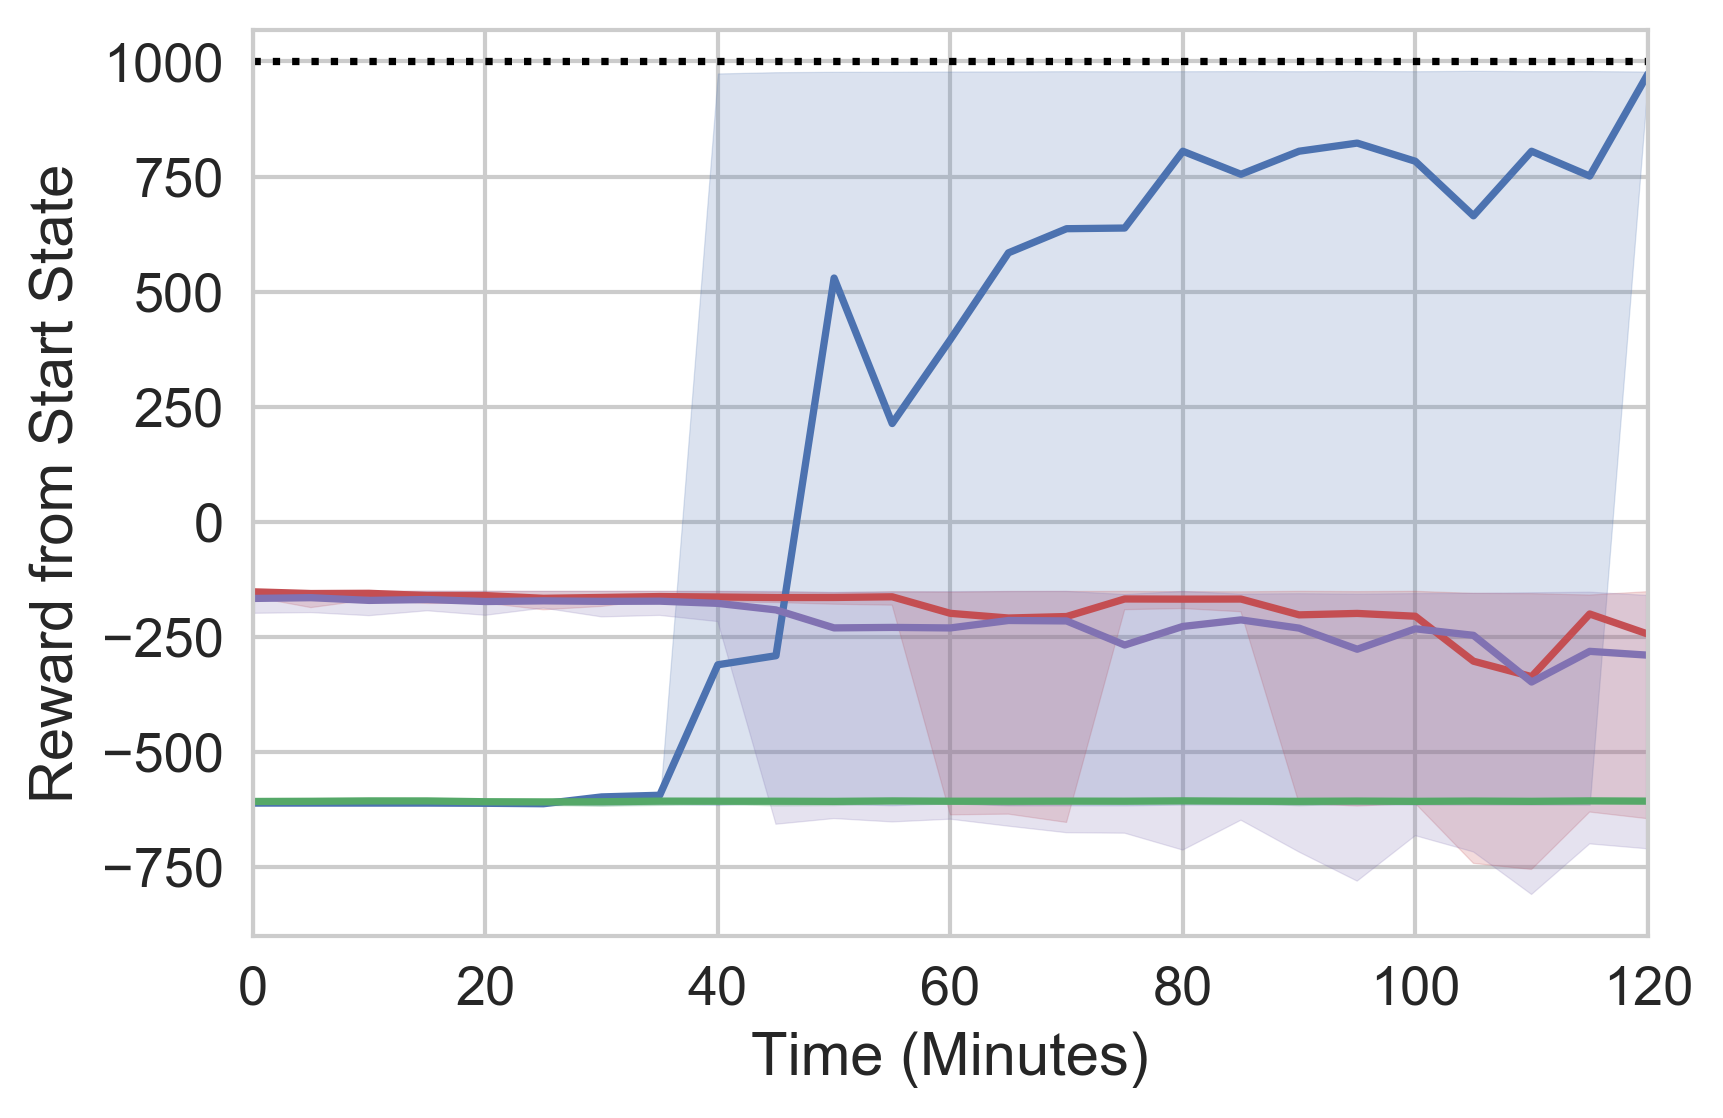

In [18]:
fig, ax = plt.subplots(dpi=300)
plot_ci_perf(ax=ax, df=our_rel_time_df, x_col='rel_time_bin', y_col='overall_perf', label='BaRC')
plot_ci_perf(ax=ax, df=random_rel_time_df, x_col='rel_time_bin', y_col='overall_perf', label='Random Curriculum')
plot_ci_perf(ax=ax, df=ppo_only_rel_time_df, x_col='rel_time_bin', y_col='overall_perf', label='PPO Only')
plot_ci_perf(ax=ax, df=ppo_only_qr_rel_time_df, x_col='rel_time_bin', y_col='overall_perf', label='PPO Only with Quadratized Reward')

ax.axhline(1000, linestyle=':', color='k');
ax.set_ylabel(r'Reward from Start State')
ax.set_xlabel('Time (Minutes)')
ax.set_xlim((0, 120))
# ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
#           mode="expand", borderaxespad=0, ncol=3,
#           frameon=True, framealpha=1.0, handlelength=1.25);
plt.savefig('figures/quad_ppo_only_quadratized_reward_minutes.pdf', dpi=300)

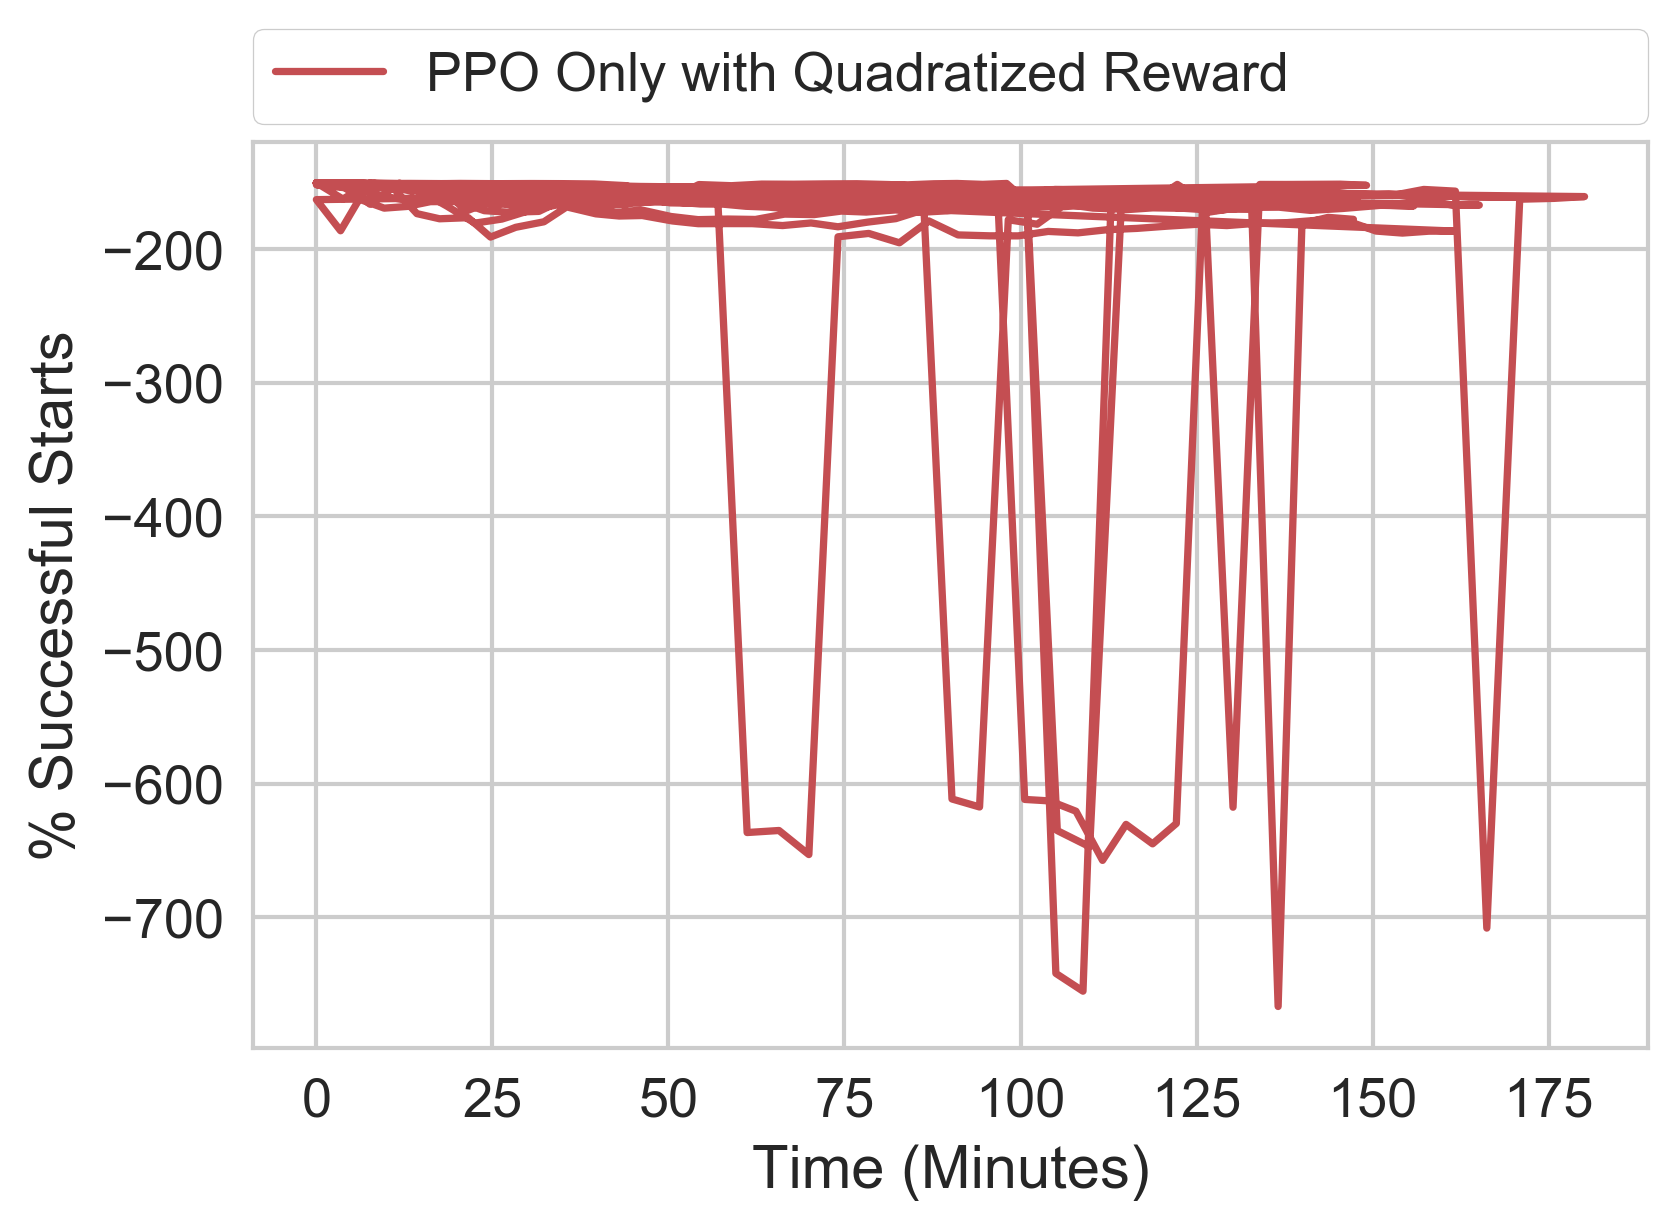

In [19]:
fig, ax = plt.subplots(dpi=300)
# ax.plot(our_df['rel_time'], our_df['overall_perf'], label='Our Method');
# ax.plot(random_df['rel_time'], random_df['overall_perf'], label='Random Curriculum');
ax.plot(ppo_only_df['rel_time'], ppo_only_df['overall_perf'], label='PPO Only with Quadratized Reward', color=sns.color_palette()[2]);
ax.set_ylabel(r'% Successful Starts')
ax.set_xlabel('Time (Minutes)')
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
          mode="expand", borderaxespad=0, ncol=3,
          frameon=True, framealpha=1.0);

In [20]:
our_df['ppo_iteration_correct'] = our_df.groupby('run_seed').cumcount()

In [21]:
our_ppo_iter_df = our_df.groupby('ppo_iteration_correct').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
random_ppo_iter_df = random_df.groupby('ppo_iter').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
ppo_only_ppo_iter_df = ppo_only_df.groupby('ppo_iter').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()
ppo_only_qr_ppo_iter_df = ppo_only_quad_rew_df.groupby('ppo_iter').agg([np.mean, percentile(2.5), percentile(97.5)]).reset_index()

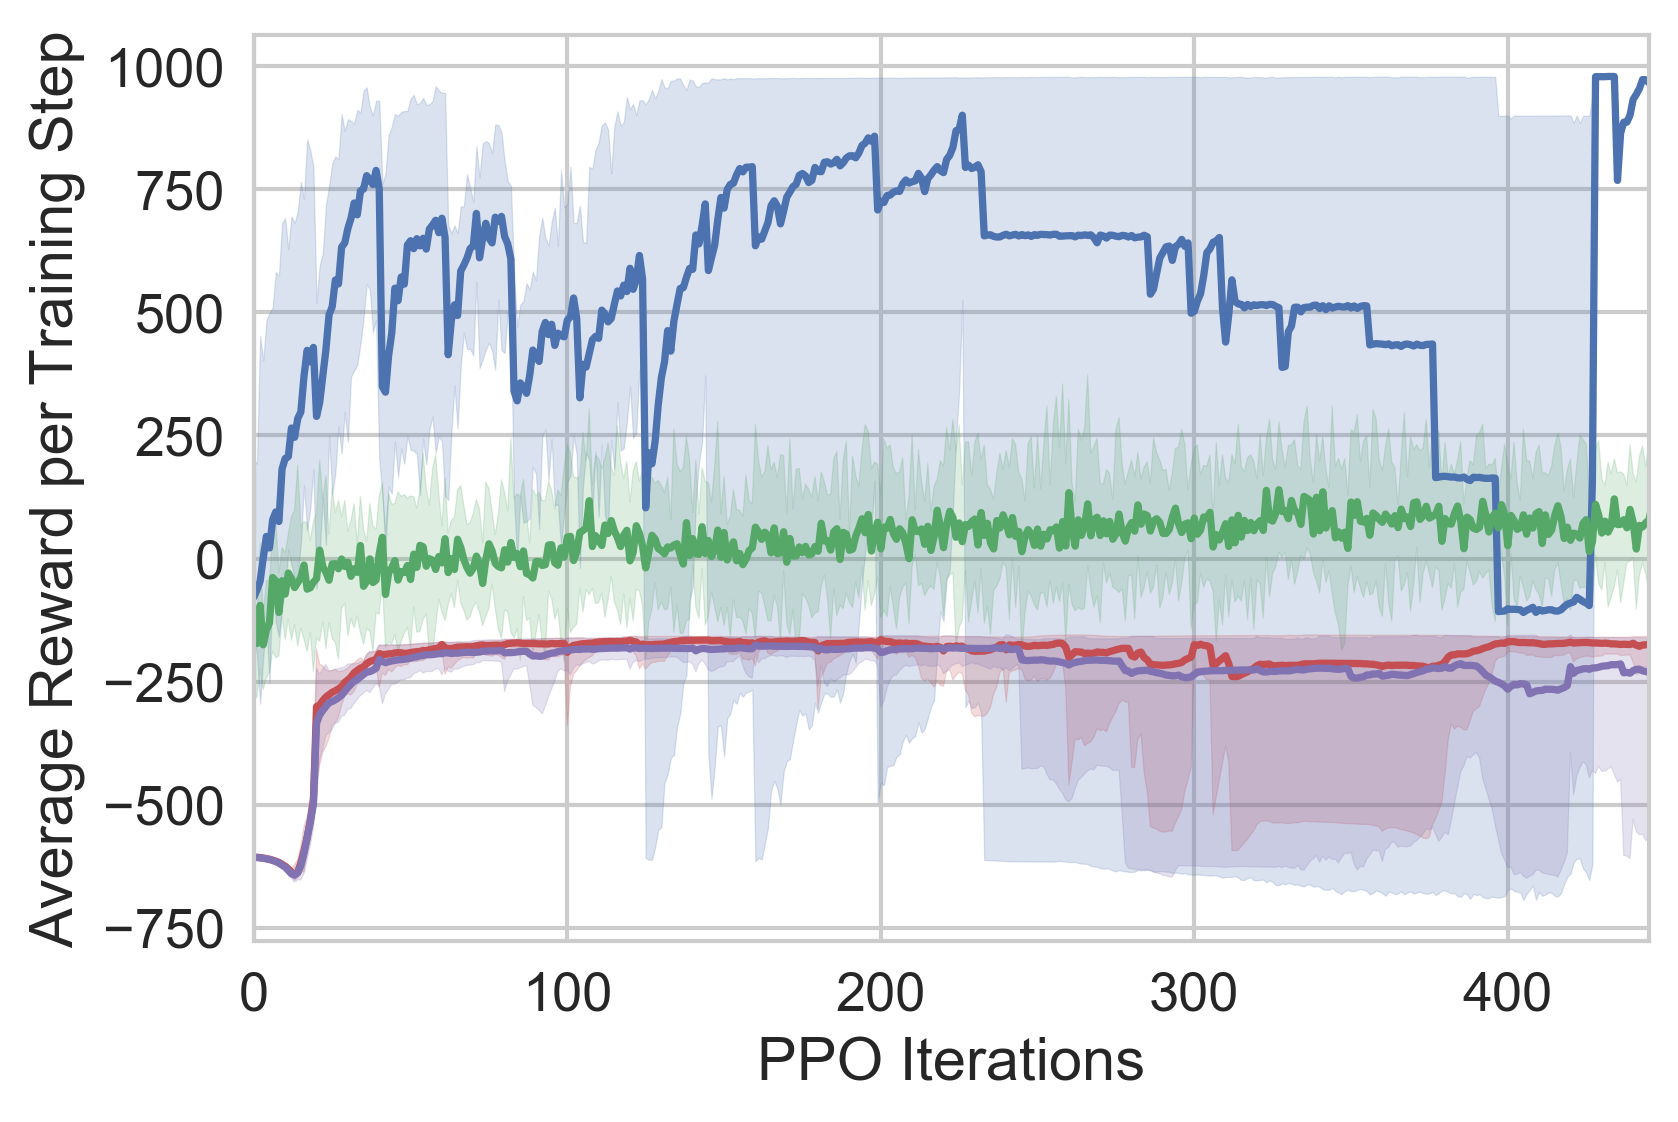

In [24]:
fig, ax = plt.subplots(dpi=300)
plot_ci_perf(ax=ax, df=our_ppo_iter_df, x_col='ppo_iteration_correct', y_col='ppo_rews', label='BaRC')
plot_ci_perf(ax=ax, df=random_ppo_iter_df, x_col='ppo_iter', y_col='ppo_rews', label='Random Curriculum')
plot_ci_perf(ax=ax, df=ppo_only_ppo_iter_df, x_col='ppo_iter', y_col='ppo_rews', label='PPO Only')
plot_ci_perf(ax=ax, df=ppo_only_qr_ppo_iter_df, x_col='ppo_iter', y_col='ppo_rews', label='PPO Only with QR')
ax.set_ylabel(r'Average Reward per Training Step')
ax.set_xlabel('PPO Iterations')
ax.set_xlim((0, 445))
# ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
#           mode="expand", borderaxespad=0, ncol=3,
#           frameon=True, framealpha=1.0, handlelength=1.25);
plt.savefig('figures/quad_ppo_only_quadratized_reward_ppo_iters.pdf', dpi=300)

In [14]:
clear all